In [75]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
from sklearn.datasets import make_blobs
from plotnine import *   
# StandardScaler is a function to normalize the data 
# You may also check MinMaxScaler and MaxAbsScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage as linkage_matrix

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
%matplotlib inline
from scipy.cluster.hierarchy import dendrogram

In [76]:
# Load data
data = pd.read_csv('customer_data.csv')

# Let's assume your data is stored in a DataFrame called 'data'


In [77]:
# Select features for clustering
X = data.iloc[:, :8].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [78]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [79]:
def pearson_correlation_distance(point1, point2):
    mean1 = np.mean(point1)
    mean2 = np.mean(point2)
    std1 = np.std(point1)
    std2 = np.std(point2)
    correlation = np.sum((point1 - mean1) * (point2 - mean2)) / (len(point1) * std1 * std2)
    return 1 - correlation



In [80]:
def GUC_Distance(Cluster_Centroids, Data_points, Distance_Type='euclidean'):
    if Distance_Type == 'euclidean':
        distance_func = euclidean_distance
    elif Distance_Type == 'pearson':
        distance_func = pearson_correlation_distance
    else:
        raise ValueError("Invalid distance type. Supported types: 'euclidean', 'pearson'")
    
    distances = np.zeros((Data_points.shape[0], Cluster_Centroids.shape[0]))
    for i, centroid in enumerate(Cluster_Centroids):
        for j, point in enumerate(Data_points):
            distances[j, i] = distance_func(centroid, point)
    
    return distances

In [81]:
def GUC_Kmean(Data_points, Number_of_Clusters, Distance_Type, max_iterations=100, tolerance=1e-4):
    #  Initialize cluster centroids randomly
    min_vals = np.min(Data_points, axis=0)
    max_vals = np.max(Data_points, axis=0)
    Cluster_Centroids = np.random.uniform(min_vals, max_vals, size=(Number_of_Clusters, Data_points.shape[1]))
    
    iteration = 0
    prev_cluster_distances = None
    
    while iteration < max_iterations:
        #  Cluster Assignment
        Cluster_Distances = GUC_Distance(Cluster_Centroids, Data_points, Distance_Type)
        Cluster_Assignments = np.argmin(Cluster_Distances, axis=1)
        
        #  Calculate mean square distance for each cluster
        cluster_distances = np.zeros(Number_of_Clusters)
        for i in range(Number_of_Clusters):
            cluster_distances[i] = np.mean(Cluster_Distances[Cluster_Assignments == i, i])
        
        #  Update centroids
        new_cluster_centroids = np.array([np.mean(Data_points[Cluster_Assignments == i], axis=0) for i in range(Number_of_Clusters)])
        
        #  Calculate cluster metric (sum of squared error)
        cluster_metric = np.sum(cluster_distances)
        
        #  Stopping condition
        if prev_cluster_distances is not None and np.abs(prev_cluster_distances - cluster_metric) < tolerance:
            break
        
        Cluster_Centroids = new_cluster_centroids
        prev_cluster_distances = cluster_metric
        iteration += 1
    
    return Cluster_Distances, cluster_metric


In [ ]:
def display_cluster(X, km=[], num_clusters=0):
    color = 'brgcmyk'  # List colors
    alpha = 0.5  # Color opacity
    s = 20

    # Determine the number of dimensions
    num_dimensions = X.shape[1]

    # Prepare the figure size and background
    plt.rcParams['figure.figsize'] = [12, 6]
    sns.set_style("whitegrid")
    sns.set_context("talk")

    if num_dimensions == 2:
        if num_clusters == 0:
            plt.scatter(X[:, 0], X[:, 1], c=color[0], alpha=alpha, s=s)
        else:
            for j in range(num_clusters):
                plt.scatter(X[km.labels_ == j, 0], X[km.labels_ == j, 1], c=color[j], alpha=alpha, s=s)
                plt.scatter(km.cluster_centers_[j][0], km.cluster_centers_[j][1], c=color[j], marker='x', s=100)
    else:
        print("Number of dimensions is not 2. Unable to display clusters.")

print(data.head())

# Extract relevant features for clustering
features = data[['ID', 'Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]

# Define the range of clusters to try
num_clusters_range = range(2, 11)

# Initialize lists to store cluster metrics for each number of clusters
cluster_metrics_euclidean = []
cluster_metrics_pearson = []

# Apply GUC_Kmean function with varying number of clusters
for num_clusters in num_clusters_range:
    # Euclidean distance
    kmeans_euclidean = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_euclidean.fit(features)
    cluster_metrics_euclidean.append(kmeans_euclidean.inertia_)

    # Pearson correlation distance
    kmeans_pearson = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_pearson.fit(features)
    cluster_metrics_pearson.append(kmeans_pearson.inertia_)

# Plot the cluster metric versus the number of clusters
plt.figure(figsize=[12, 6])
plt.plot(num_clusters_range, cluster_metrics_euclidean, marker='o', label='Euclidean Distance')
plt.plot(num_clusters_range, cluster_metrics_pearson, marker='o', label='Pearson Correlation Distance')
plt.title('Cluster Metric versus Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Metric')
plt.legend()
plt.grid(True)
plt.show()

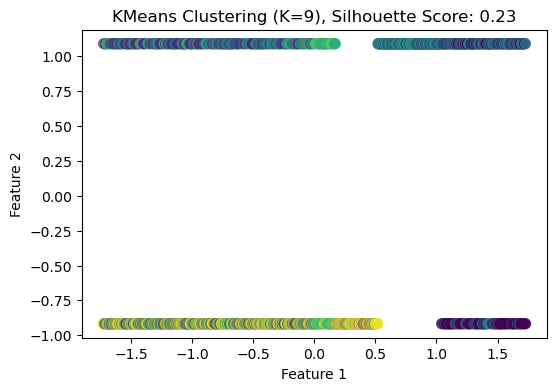

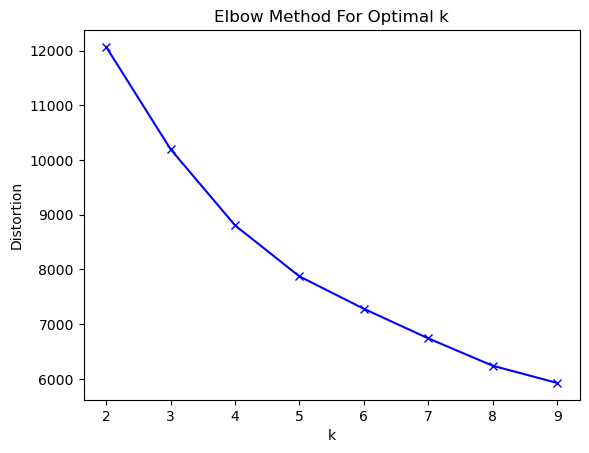

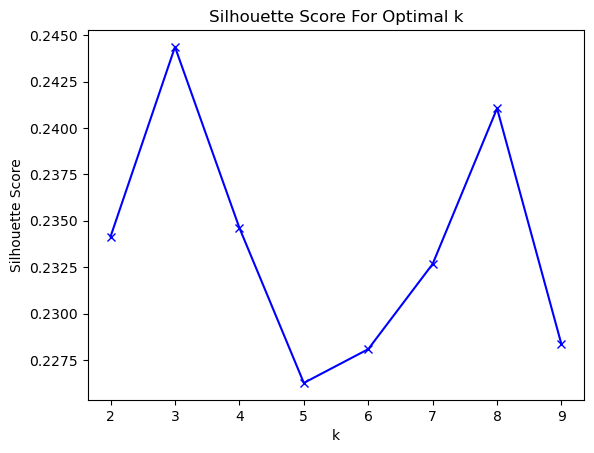

In [93]:
# Perform KMeans clustering
distortions = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot clusters
plt.figure(figsize=(6, 4))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.5)
plt.title(f'KMeans Clustering (K={k}), Silhouette Score: {silhouette_scores[-1]:.2f}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Plot distortion function
plt.plot(K_range, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()

# Plot silhouette score
plt.plot(K_range, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()


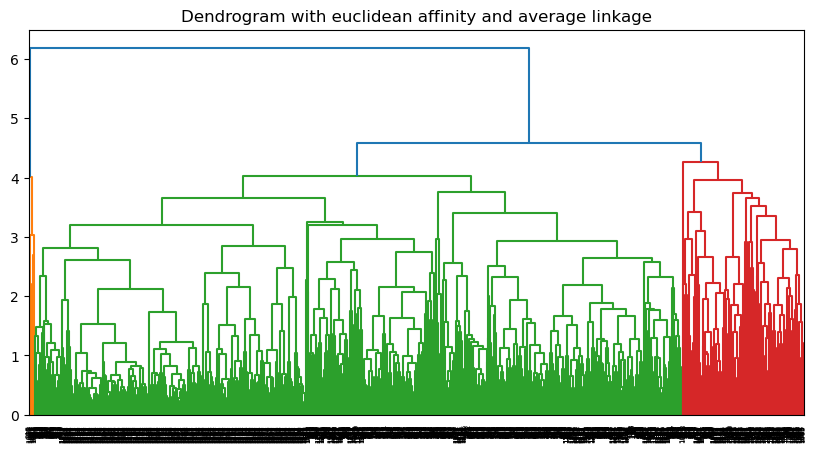

Silhouette Score with euclidean affinity and average linkage: 0.36592852067351805


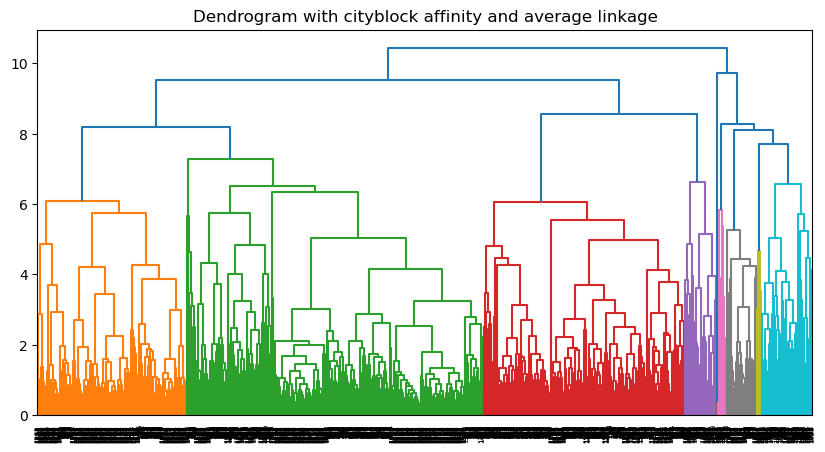

Silhouette Score with cityblock affinity and average linkage: 0.20536034264399053


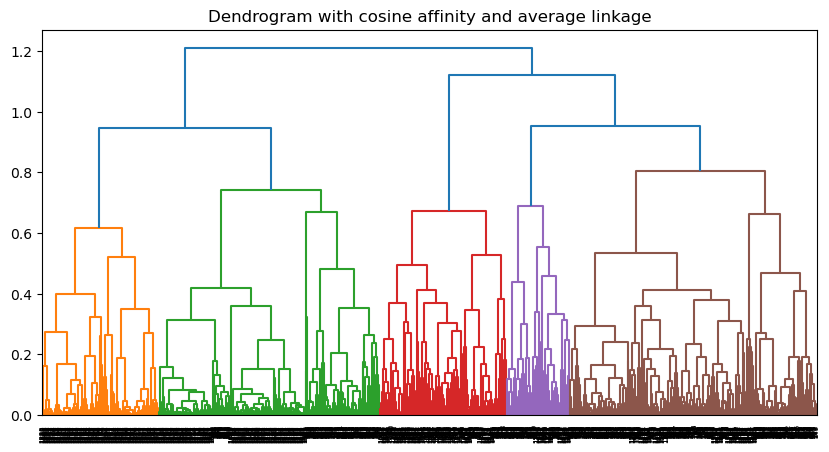

Silhouette Score with cosine affinity and average linkage: 0.19383718113668486


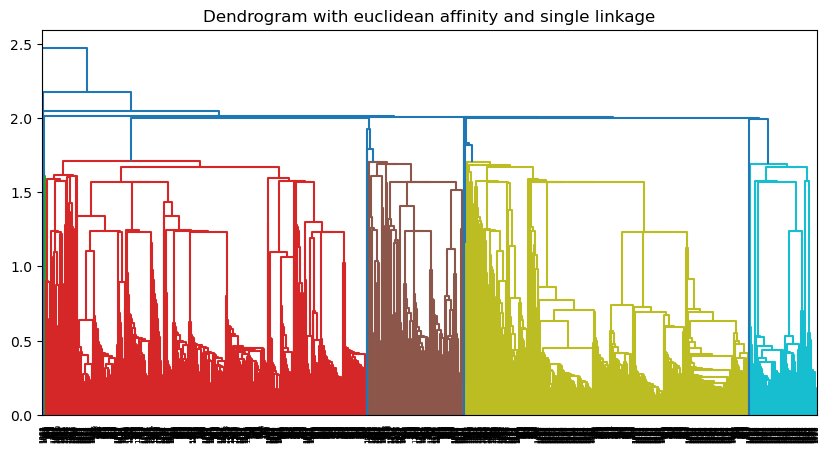

Silhouette Score with euclidean affinity and single linkage: 0.30991073468773084


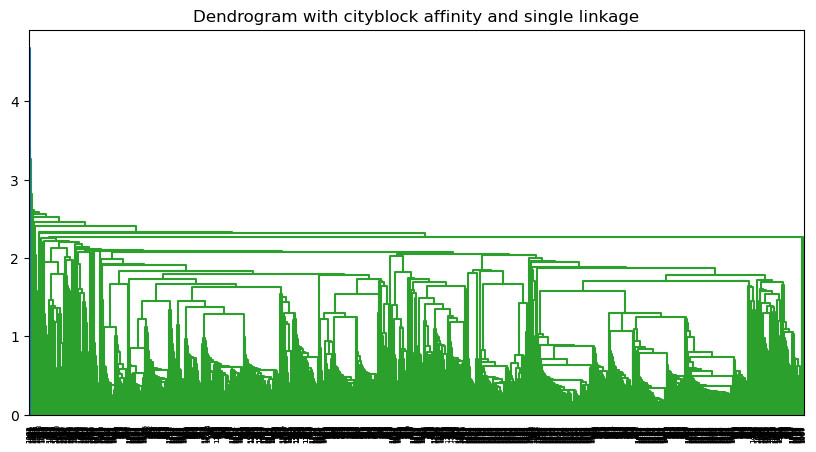

Silhouette Score with cityblock affinity and single linkage: 0.30991073468773084


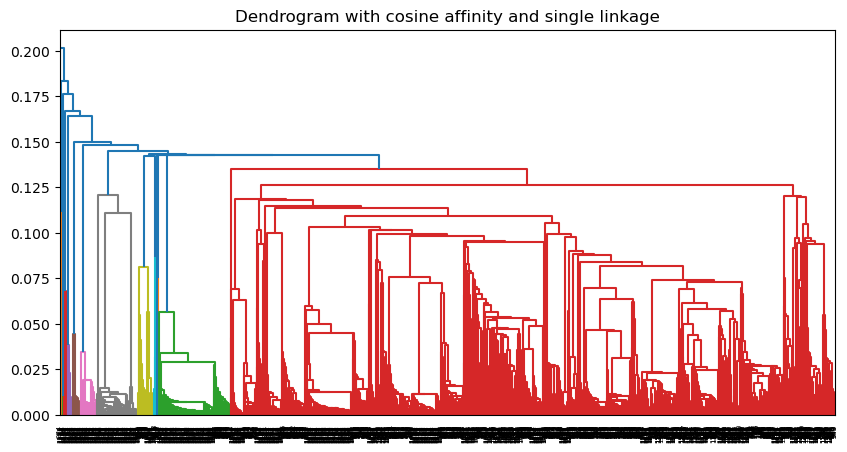

Silhouette Score with cosine affinity and single linkage: 0.024081288003810684
Best Parameters: {'affinity': 'euclidean', 'linkage': 'average'}
Best Silhouette Score: 0.36592852067351805


In [64]:
#import pandas as pd
import matplotlib.pyplot as plt
#from scipy.cluster.hierarchy import dendrogram, linkage
#from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Perform Hierarchical Clustering
def perform_hierarchical_clustering(X):
    # Try different parameters
    parameters = [
        {'affinity': 'euclidean', 'linkage': 'average'},
        {'affinity': 'cityblock', 'linkage': 'average'},  # Change to cityblock
        {'affinity': 'cosine', 'linkage': 'average'},
        {'affinity': 'euclidean', 'linkage': 'single'},
        {'affinity': 'cityblock', 'linkage': 'single'},   # Change to cityblock
        {'affinity': 'cosine', 'linkage': 'single'}
    ]
    best_silhouette_score = -1
    best_params = None

    for param in parameters:
        model = AgglomerativeClustering(affinity=param['affinity'], linkage=param['linkage'])
        labels = model.fit_predict(X)
        silhouette_score_value = silhouette_score(X, labels)
        if silhouette_score_value > best_silhouette_score:
            best_silhouette_score = silhouette_score_value
            best_params = param

        # Compute linkage matrix
        Z = linkage(X, method=param['linkage'], metric=param['affinity'])

        # Plot dendrogram
        plt.figure(figsize=(10, 5))
        dendrogram(Z)
        plt.title(f"Dendrogram with {param['affinity']} affinity and {param['linkage']} linkage")
        plt.show()

        print(f"Silhouette Score with {param['affinity']} affinity and {param['linkage']} linkage: {silhouette_score_value}")

    return best_params, best_silhouette_score

# Main
best_params, best_silhouette_score = perform_hierarchical_clustering(X_scaled)

print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_silhouette_score)


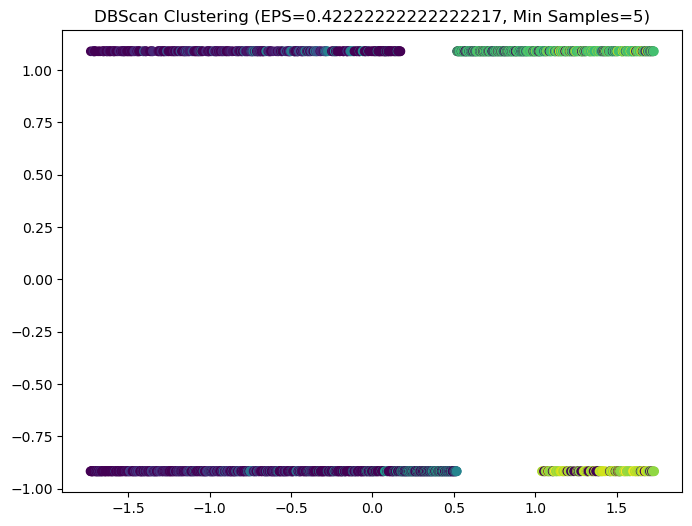

EPS: 0.42222222222222217, Min Samples: 5, Silhouette Score: -0.033749698810329055


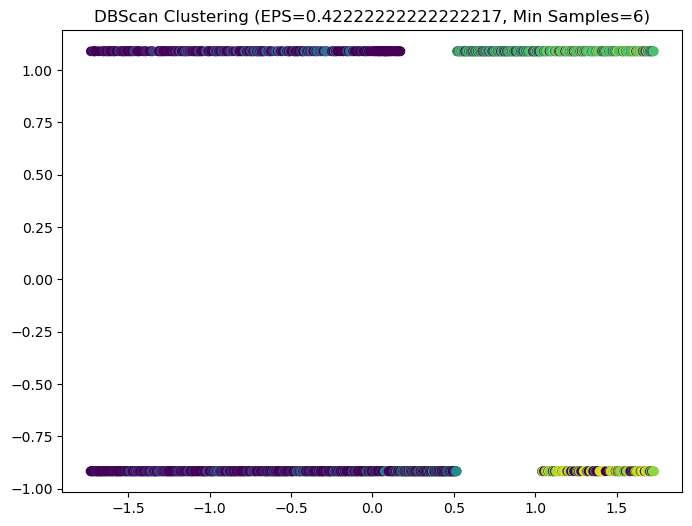

EPS: 0.42222222222222217, Min Samples: 6, Silhouette Score: -0.04262826530484076


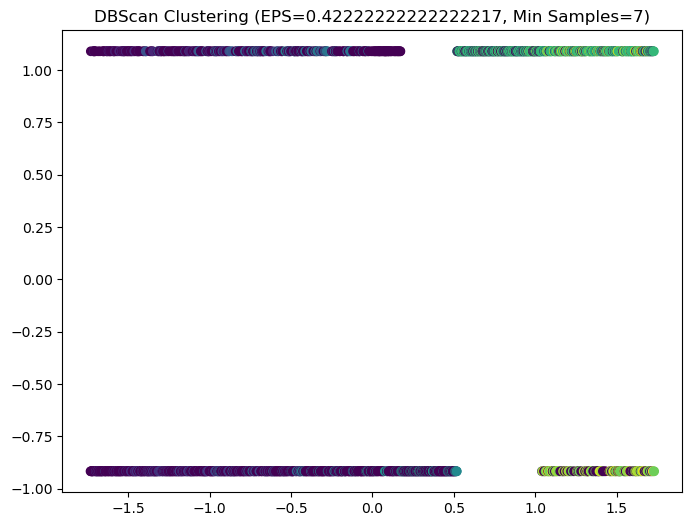

EPS: 0.42222222222222217, Min Samples: 7, Silhouette Score: -0.08353239299266474


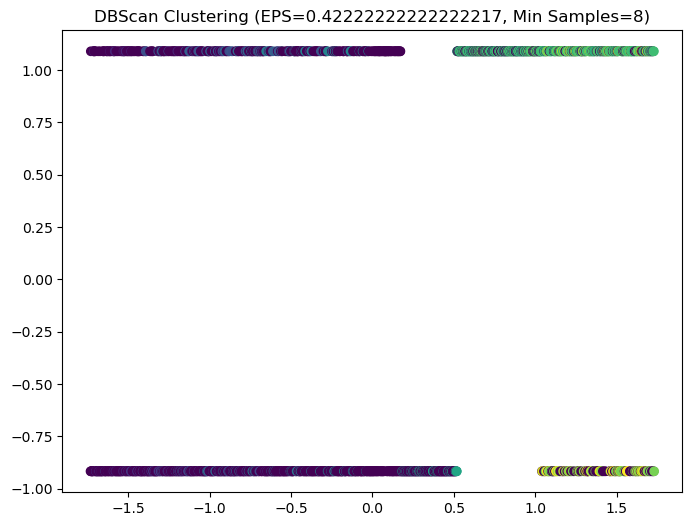

EPS: 0.42222222222222217, Min Samples: 8, Silhouette Score: -0.11728238229524454


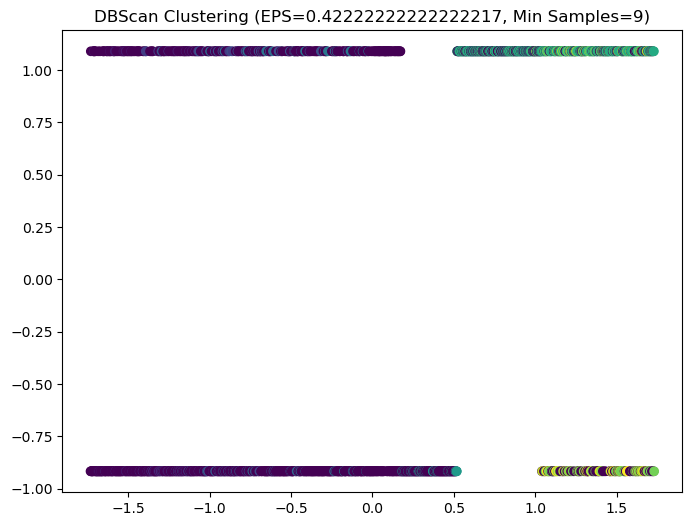

EPS: 0.42222222222222217, Min Samples: 9, Silhouette Score: -0.14536555898496362


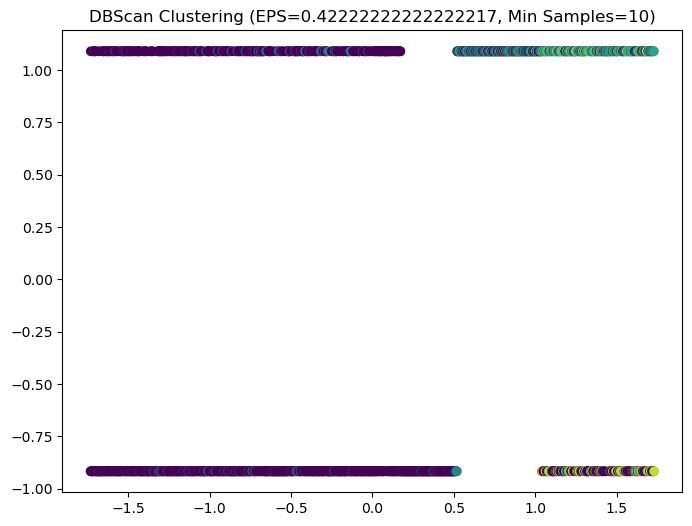

EPS: 0.42222222222222217, Min Samples: 10, Silhouette Score: -0.17488801775974652


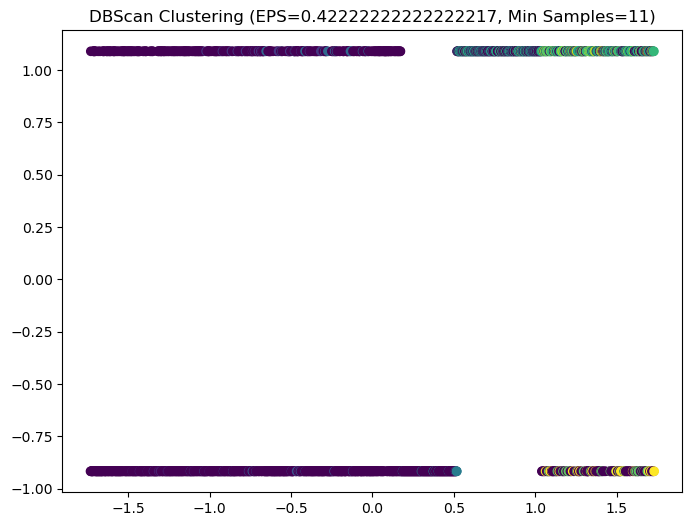

EPS: 0.42222222222222217, Min Samples: 11, Silhouette Score: -0.19733758979112395


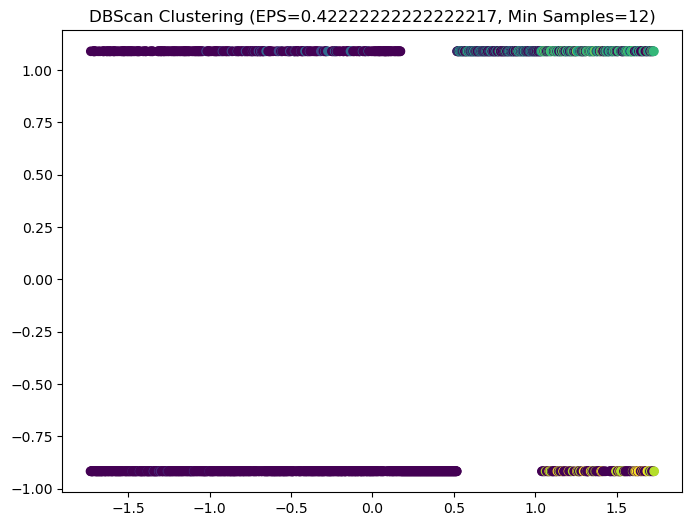

EPS: 0.42222222222222217, Min Samples: 12, Silhouette Score: -0.17940929079689055


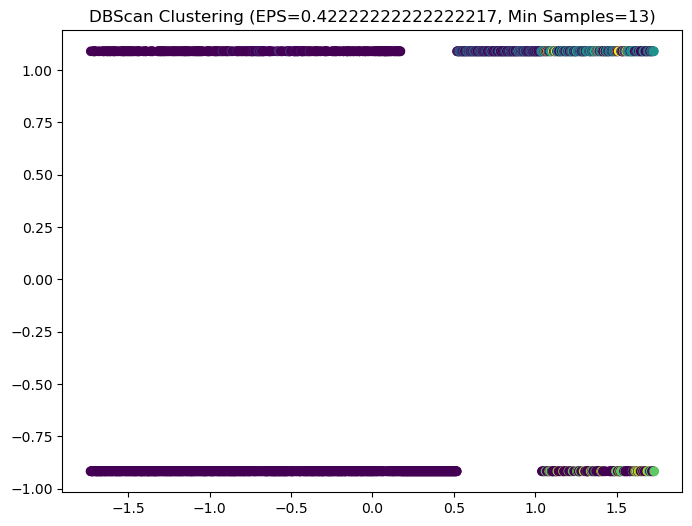

EPS: 0.42222222222222217, Min Samples: 13, Silhouette Score: -0.13475865738440818


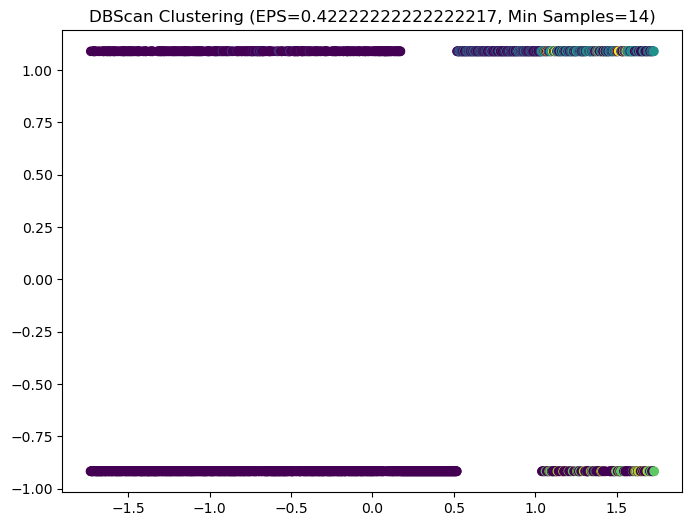

EPS: 0.42222222222222217, Min Samples: 14, Silhouette Score: -0.13771878433529347


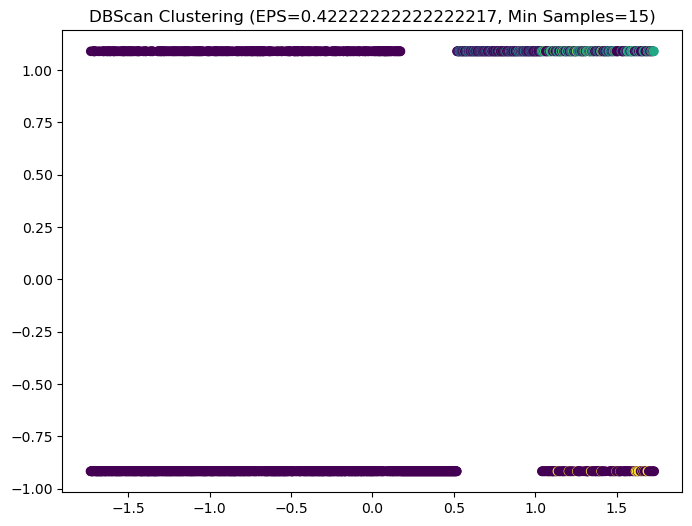

EPS: 0.42222222222222217, Min Samples: 15, Silhouette Score: -0.10463246651711054


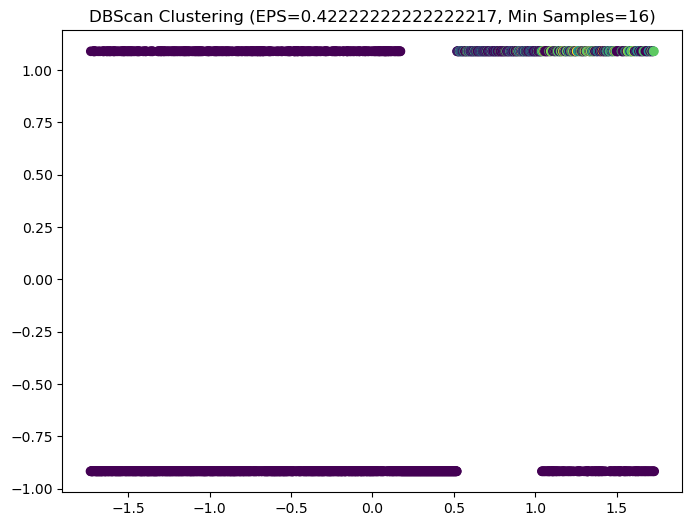

EPS: 0.42222222222222217, Min Samples: 16, Silhouette Score: -0.08935785354838506


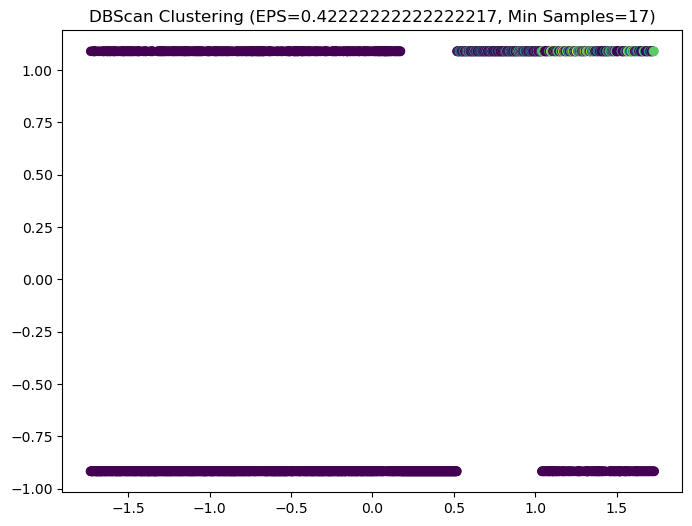

EPS: 0.42222222222222217, Min Samples: 17, Silhouette Score: -0.0964943421298497


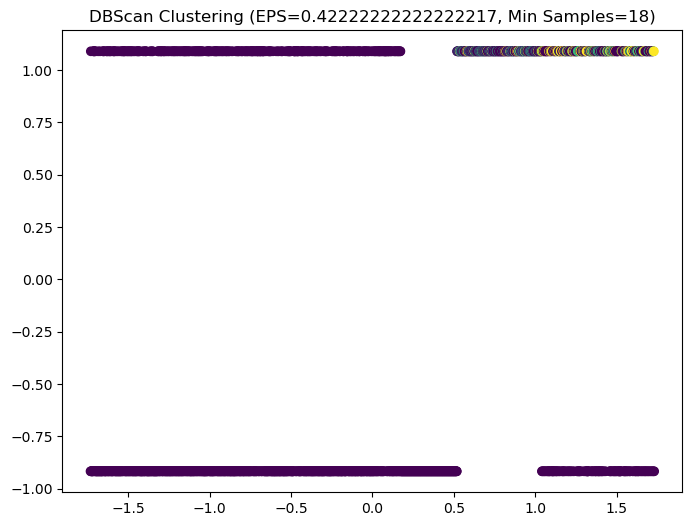

EPS: 0.42222222222222217, Min Samples: 18, Silhouette Score: -0.07178796491281397


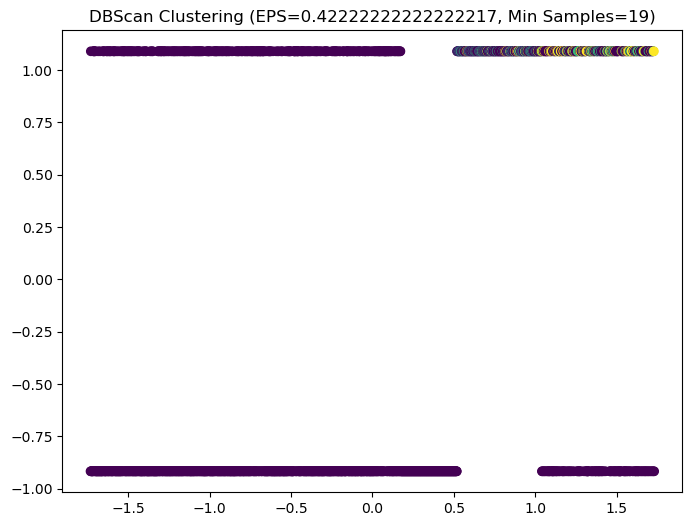

EPS: 0.42222222222222217, Min Samples: 19, Silhouette Score: -0.07386225949909593


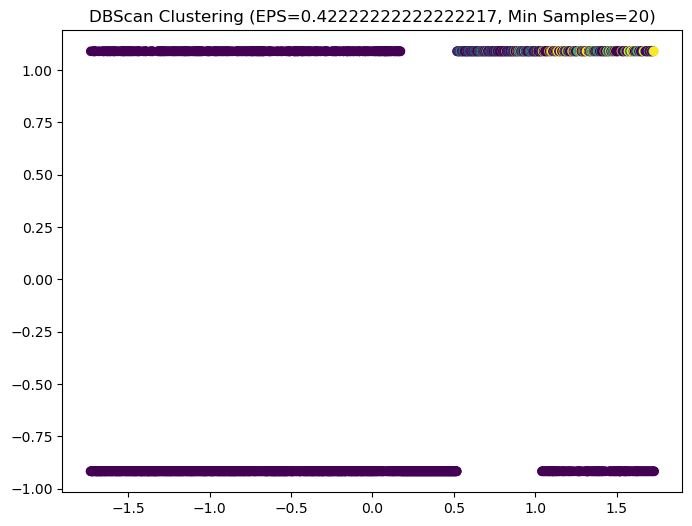

EPS: 0.42222222222222217, Min Samples: 20, Silhouette Score: -0.08169042986129259


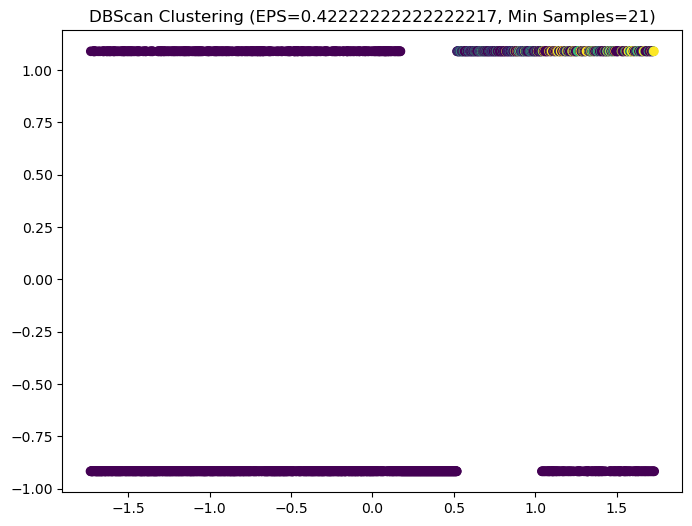

EPS: 0.42222222222222217, Min Samples: 21, Silhouette Score: -0.08304510032801525


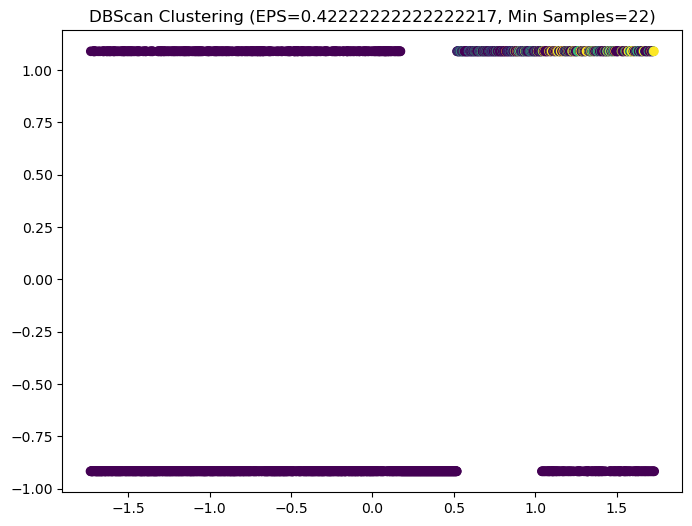

EPS: 0.42222222222222217, Min Samples: 22, Silhouette Score: -0.08777701813289053


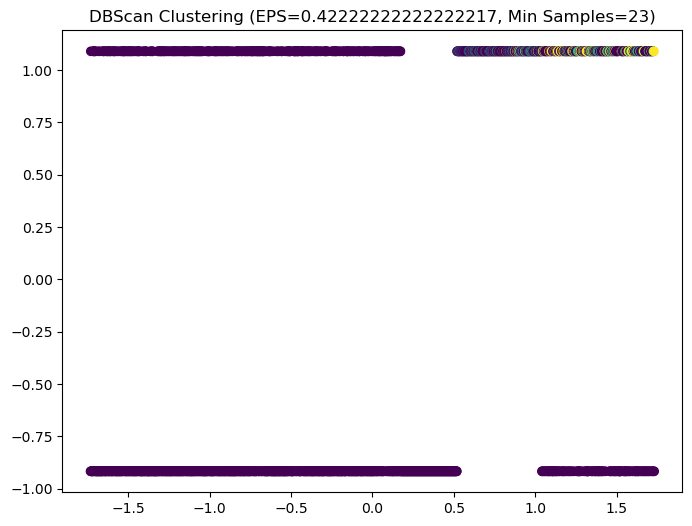

EPS: 0.42222222222222217, Min Samples: 23, Silhouette Score: -0.09243581347438372


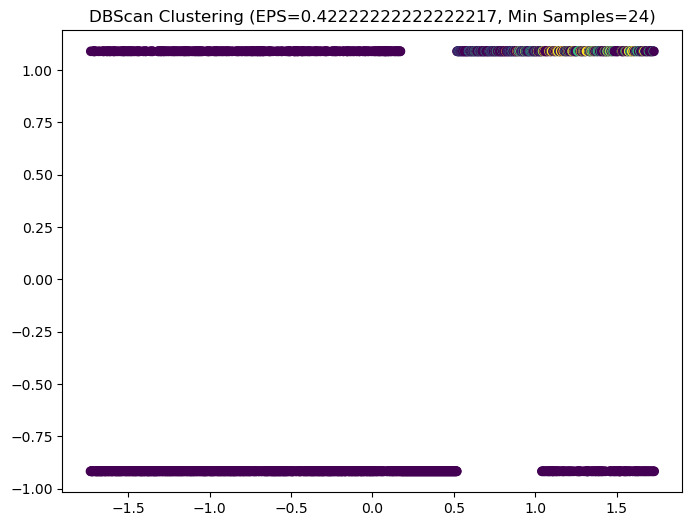

EPS: 0.42222222222222217, Min Samples: 24, Silhouette Score: -0.09955843611204034


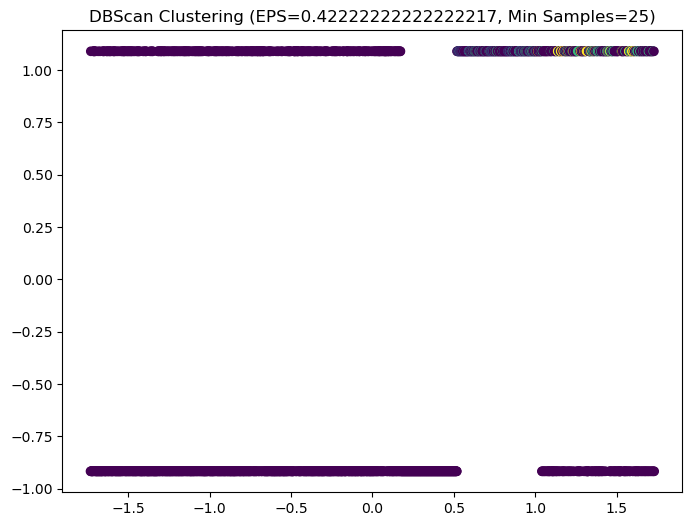

EPS: 0.42222222222222217, Min Samples: 25, Silhouette Score: -0.11638473803162588


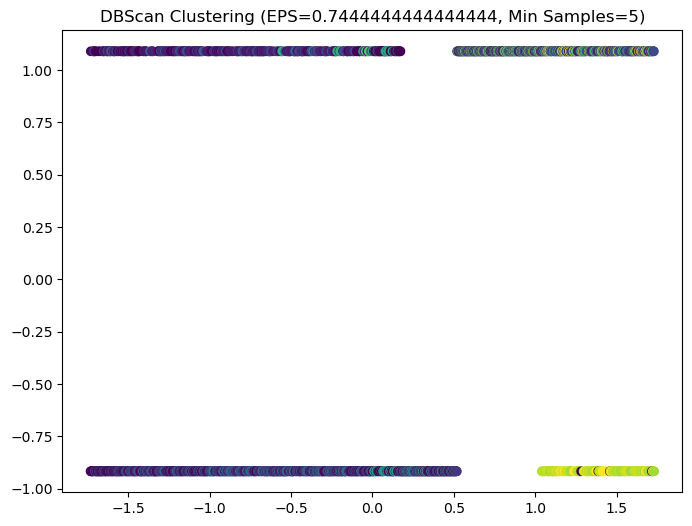

EPS: 0.7444444444444444, Min Samples: 5, Silhouette Score: 0.23177382410630906


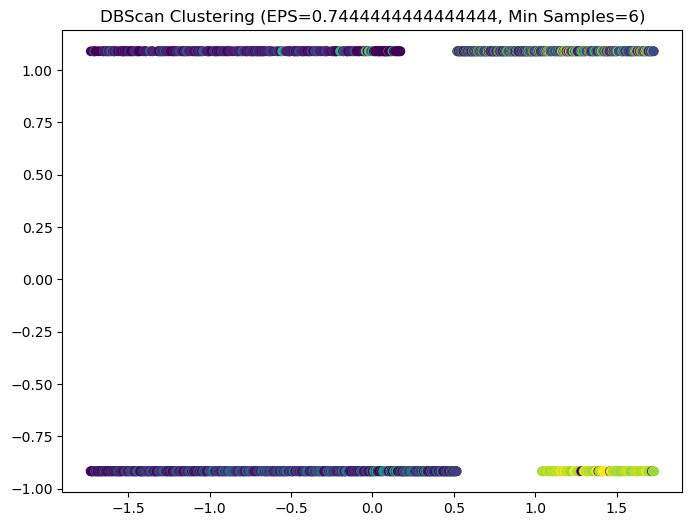

EPS: 0.7444444444444444, Min Samples: 6, Silhouette Score: 0.21978322557783392


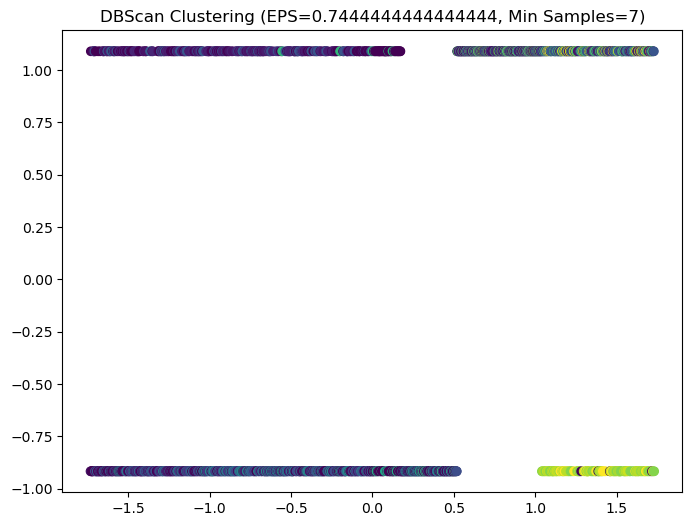

EPS: 0.7444444444444444, Min Samples: 7, Silhouette Score: 0.19399759831325247


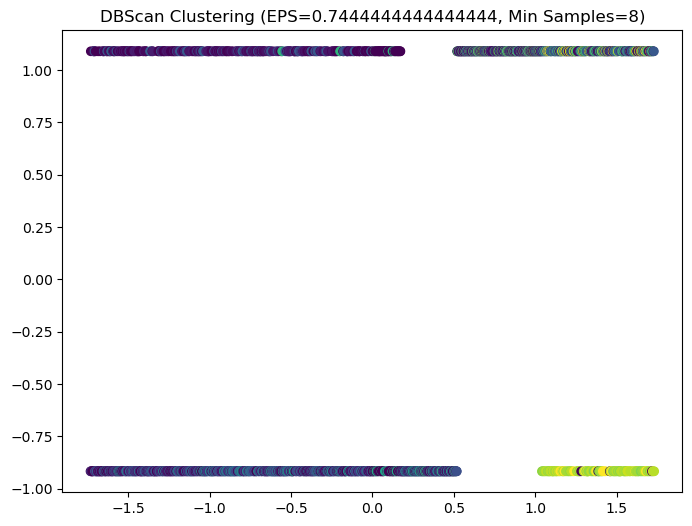

EPS: 0.7444444444444444, Min Samples: 8, Silhouette Score: 0.18027965383441535


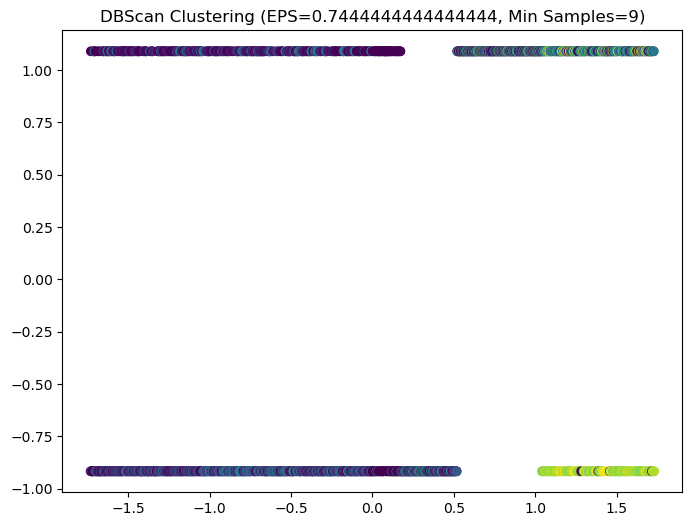

EPS: 0.7444444444444444, Min Samples: 9, Silhouette Score: 0.16649266506958404


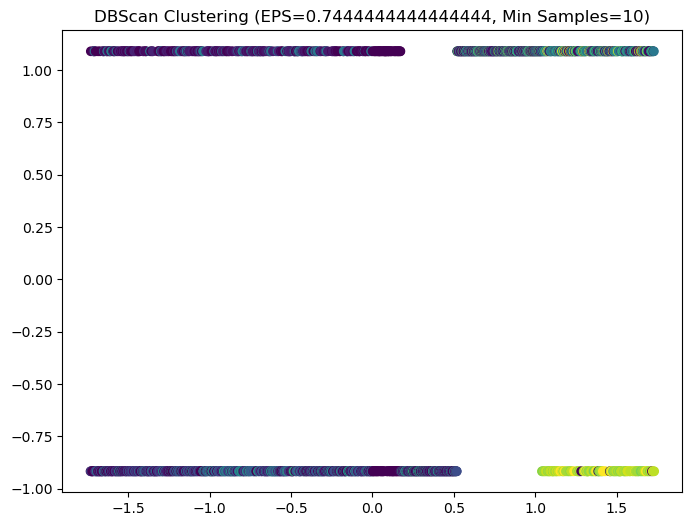

EPS: 0.7444444444444444, Min Samples: 10, Silhouette Score: 0.1592214842014841


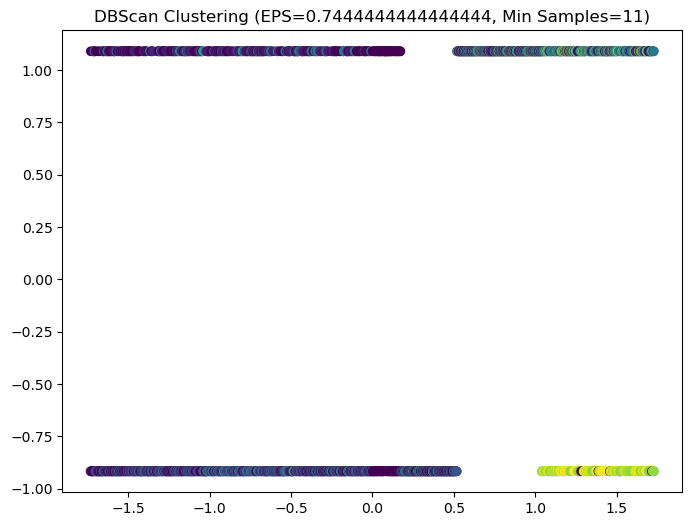

EPS: 0.7444444444444444, Min Samples: 11, Silhouette Score: 0.1463581675479562


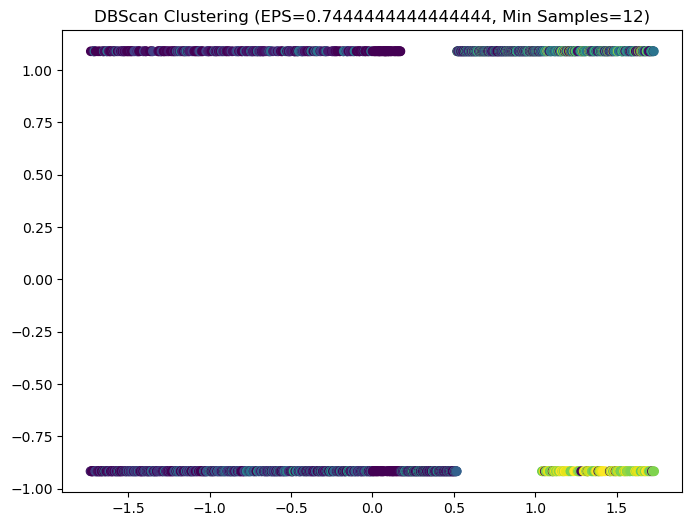

EPS: 0.7444444444444444, Min Samples: 12, Silhouette Score: 0.12577764137963157


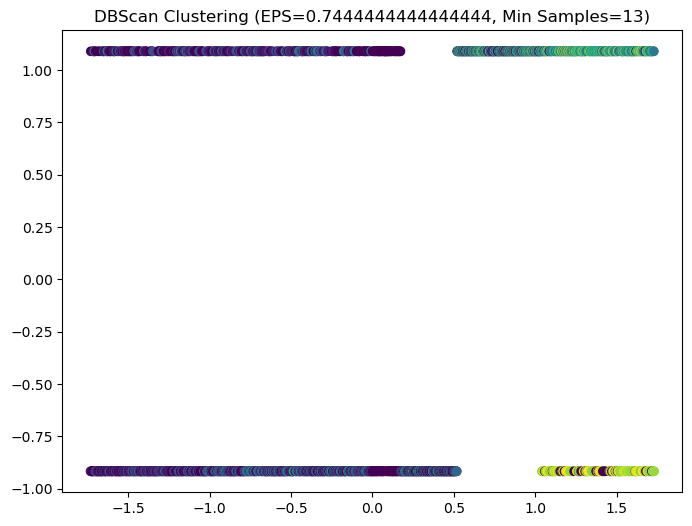

EPS: 0.7444444444444444, Min Samples: 13, Silhouette Score: 0.11486416349848022


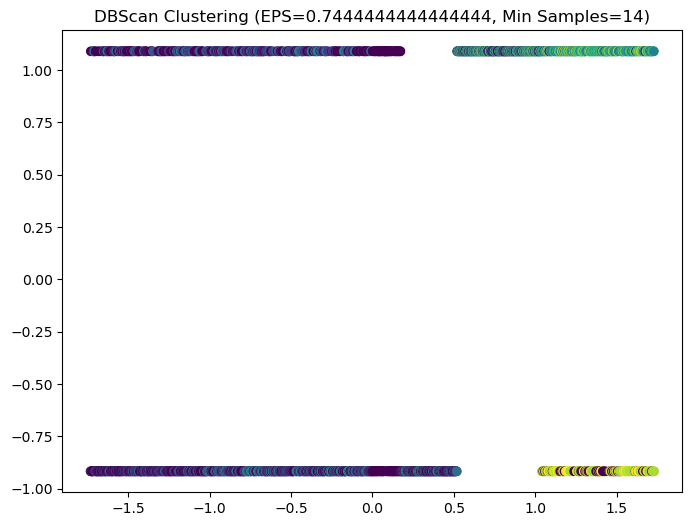

EPS: 0.7444444444444444, Min Samples: 14, Silhouette Score: 0.10276529579609962


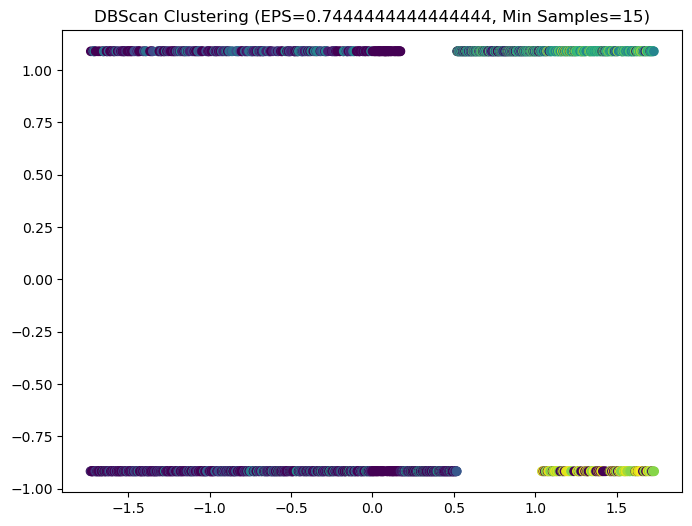

EPS: 0.7444444444444444, Min Samples: 15, Silhouette Score: 0.08574479147858546


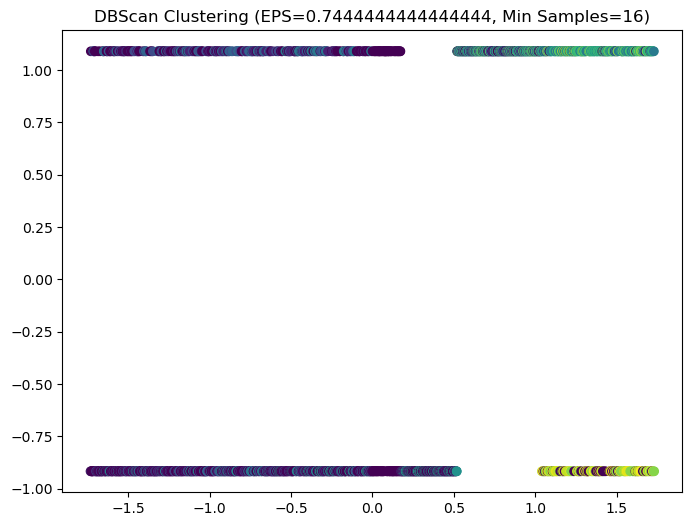

EPS: 0.7444444444444444, Min Samples: 16, Silhouette Score: 0.07921663701380603


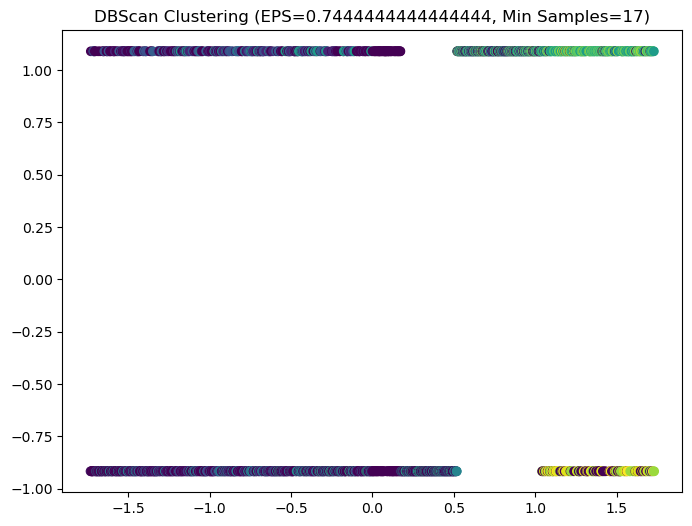

EPS: 0.7444444444444444, Min Samples: 17, Silhouette Score: 0.06665410102311868


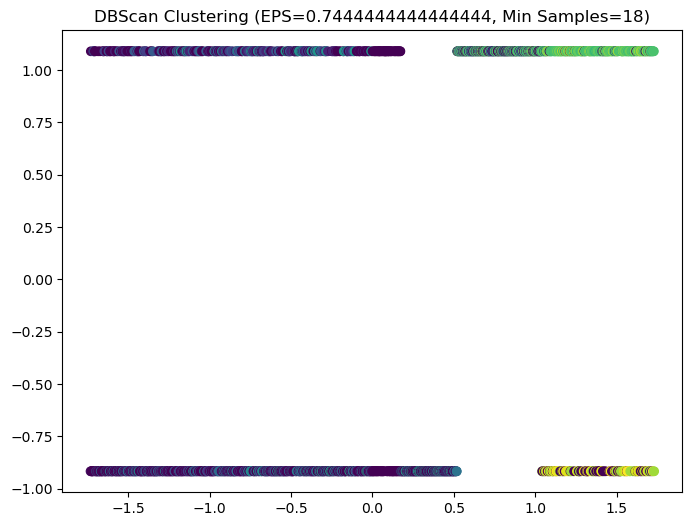

EPS: 0.7444444444444444, Min Samples: 18, Silhouette Score: 0.07091866168240332


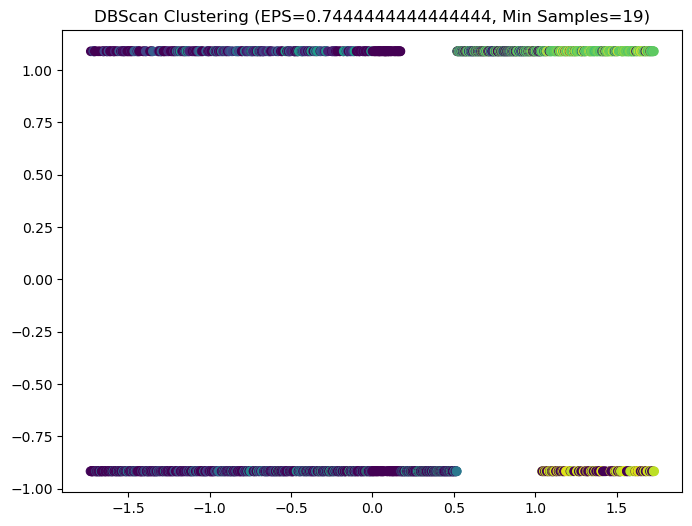

EPS: 0.7444444444444444, Min Samples: 19, Silhouette Score: 0.054401439486365694


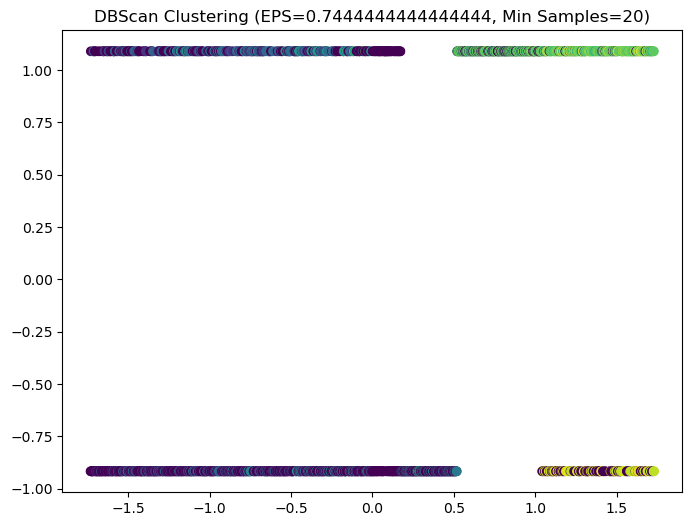

EPS: 0.7444444444444444, Min Samples: 20, Silhouette Score: 0.048410942739300876


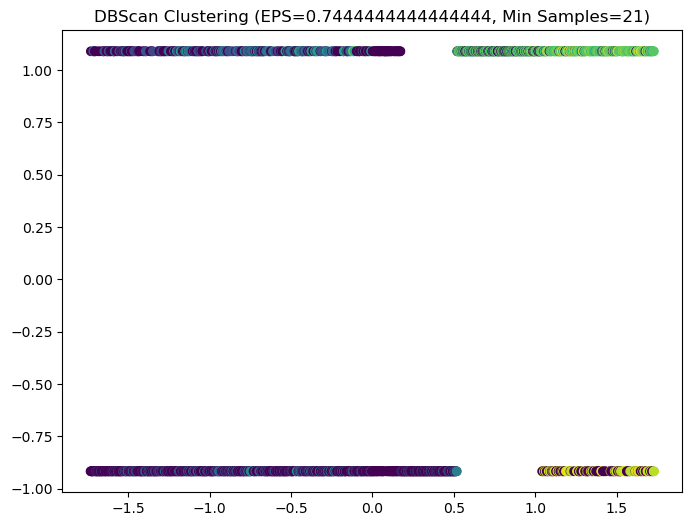

EPS: 0.7444444444444444, Min Samples: 21, Silhouette Score: 0.041604537453569734


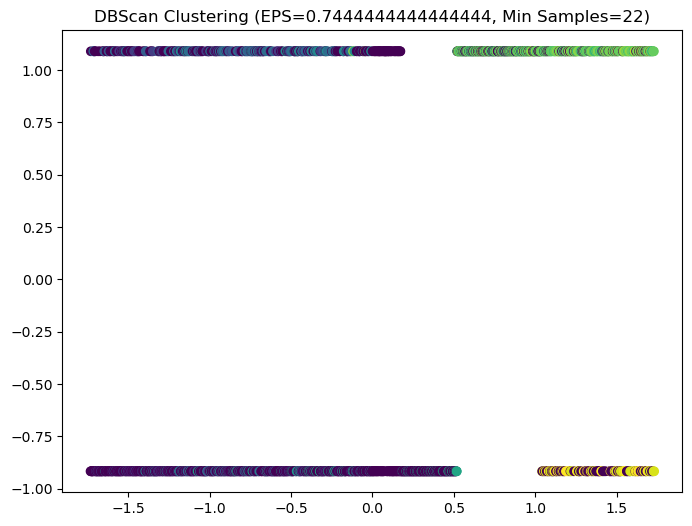

EPS: 0.7444444444444444, Min Samples: 22, Silhouette Score: 0.009448293366600843


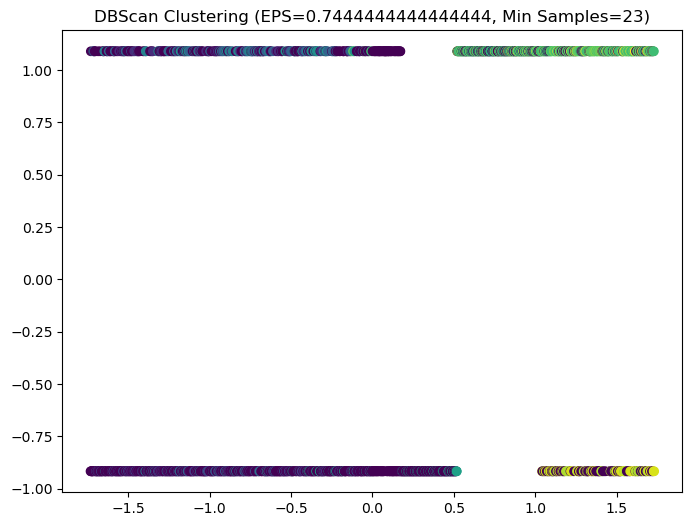

EPS: 0.7444444444444444, Min Samples: 23, Silhouette Score: -0.01931078035123749


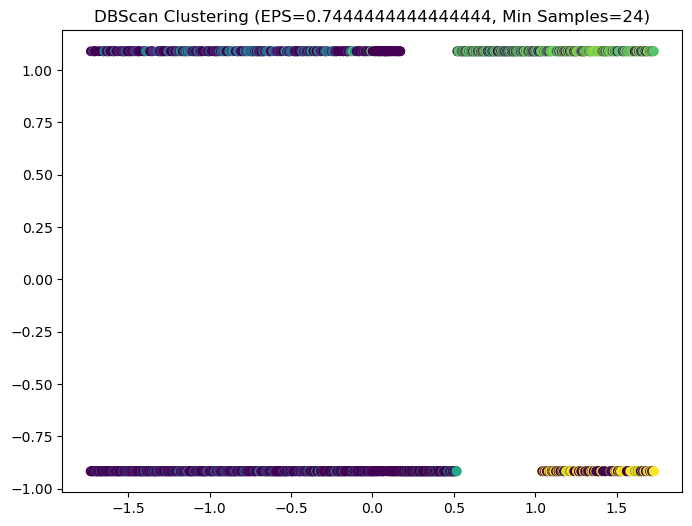

EPS: 0.7444444444444444, Min Samples: 24, Silhouette Score: -0.03436727216742806


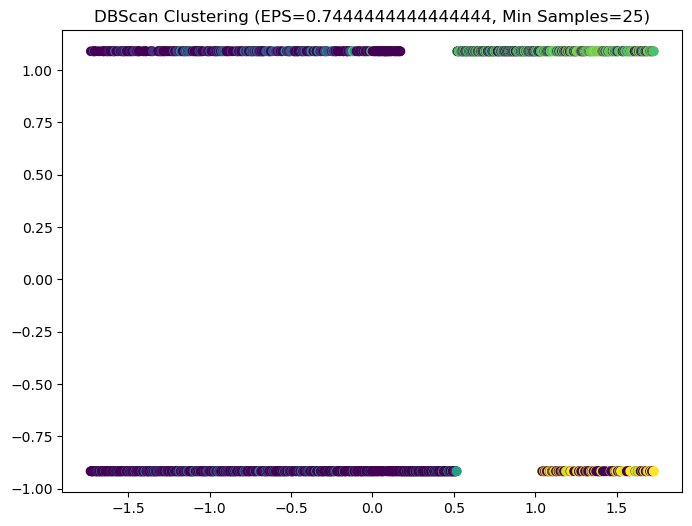

EPS: 0.7444444444444444, Min Samples: 25, Silhouette Score: -0.0573040253266701


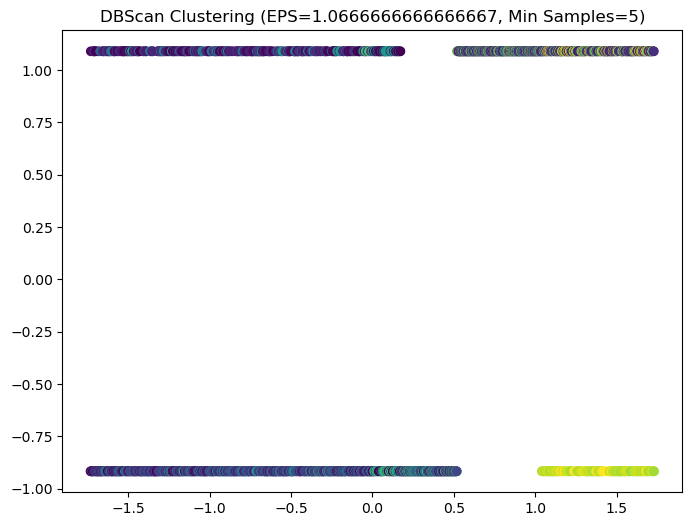

EPS: 1.0666666666666667, Min Samples: 5, Silhouette Score: 0.2808996225254021


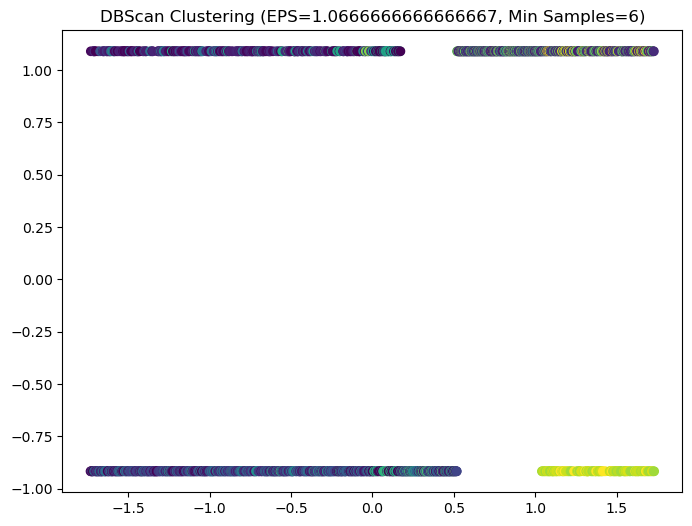

EPS: 1.0666666666666667, Min Samples: 6, Silhouette Score: 0.2731893178233834


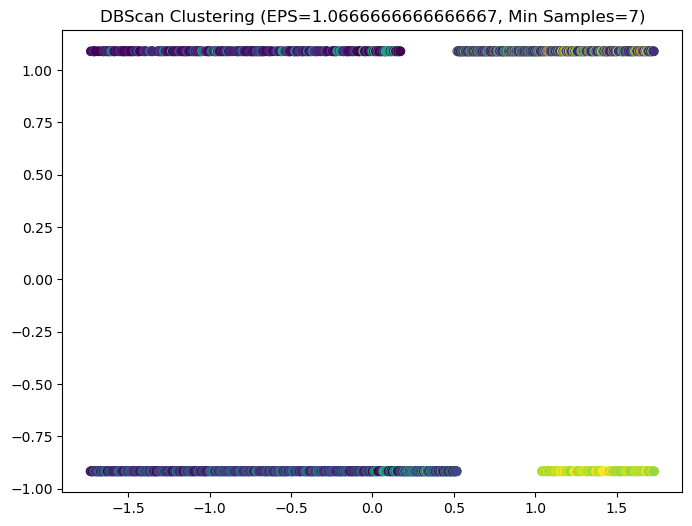

EPS: 1.0666666666666667, Min Samples: 7, Silhouette Score: 0.2640360785416381


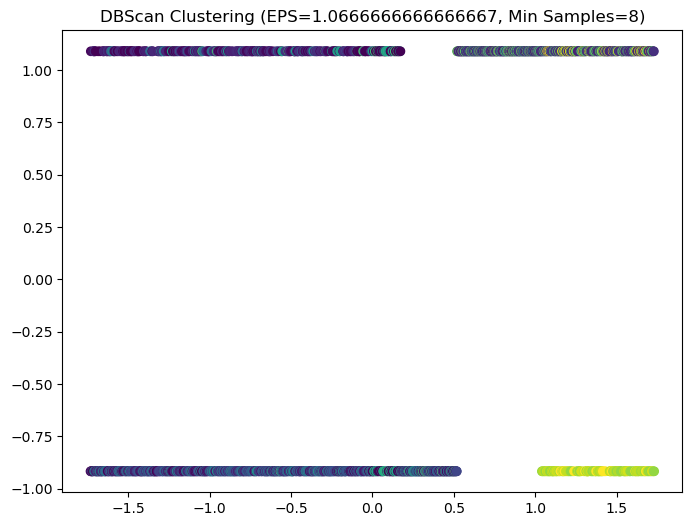

EPS: 1.0666666666666667, Min Samples: 8, Silhouette Score: 0.2581221681374479


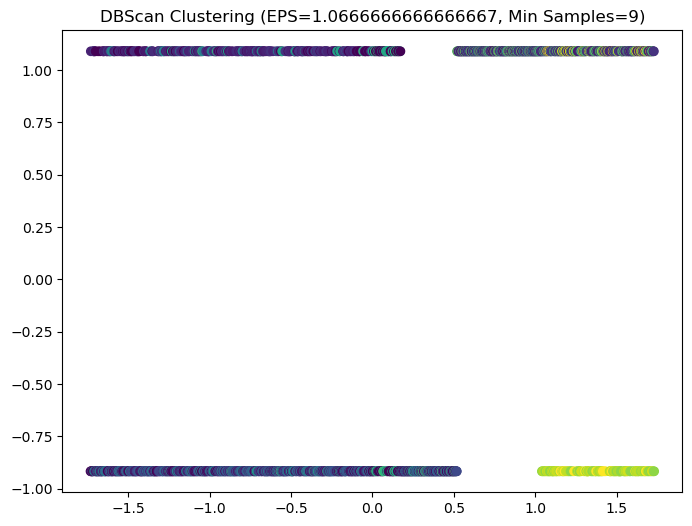

EPS: 1.0666666666666667, Min Samples: 9, Silhouette Score: 0.24531113764585297


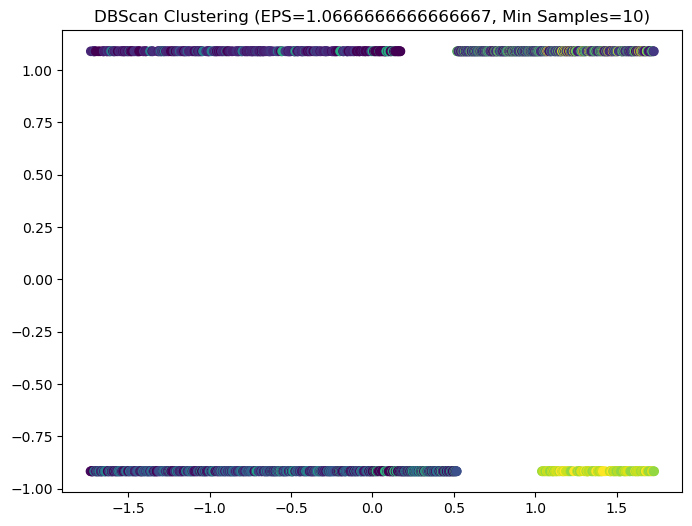

EPS: 1.0666666666666667, Min Samples: 10, Silhouette Score: 0.2322697817496775


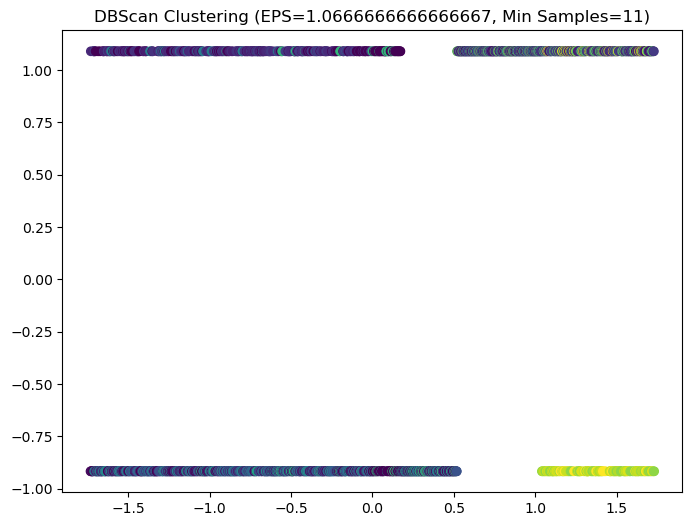

EPS: 1.0666666666666667, Min Samples: 11, Silhouette Score: 0.22251392697580363


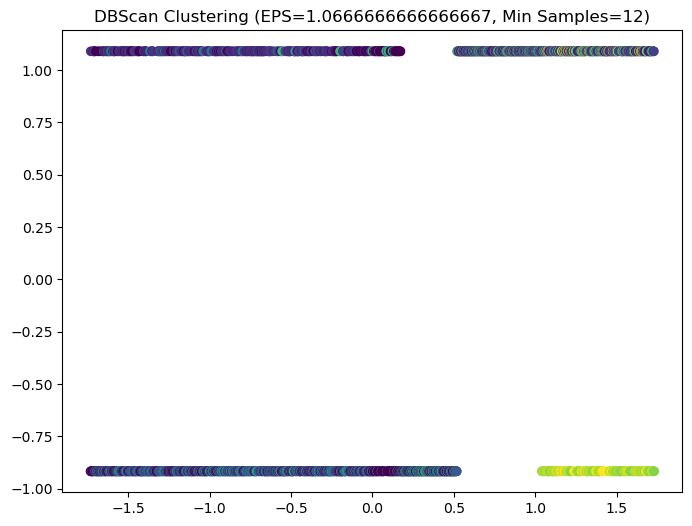

EPS: 1.0666666666666667, Min Samples: 12, Silhouette Score: 0.21068801323729594


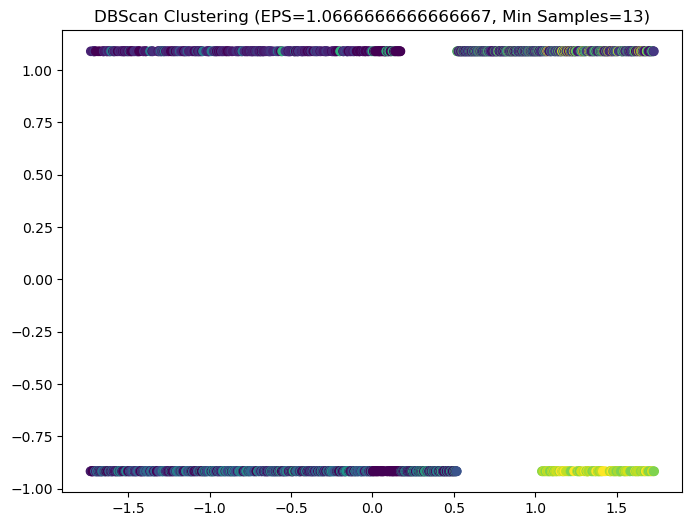

EPS: 1.0666666666666667, Min Samples: 13, Silhouette Score: 0.20760234341481817


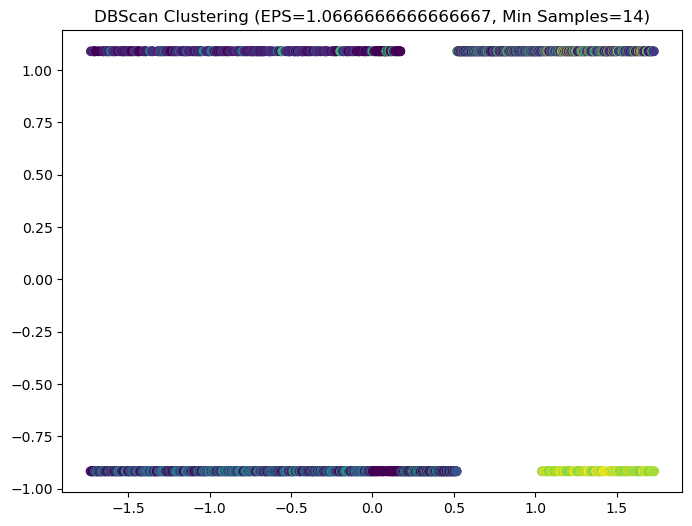

EPS: 1.0666666666666667, Min Samples: 14, Silhouette Score: 0.20060735690430181


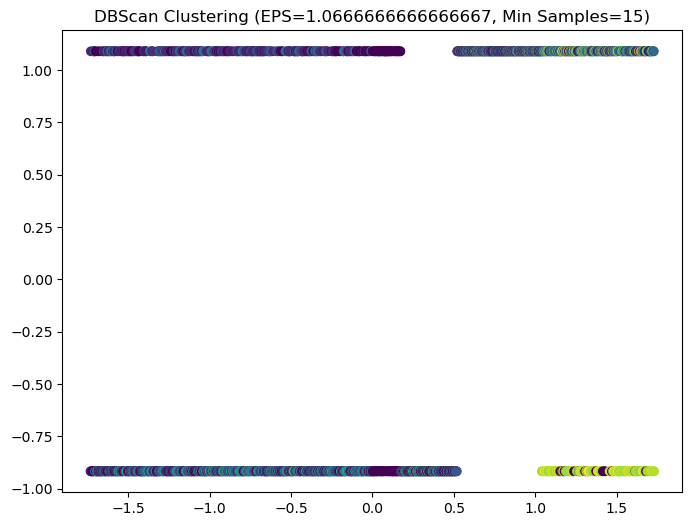

EPS: 1.0666666666666667, Min Samples: 15, Silhouette Score: 0.1954302972908629


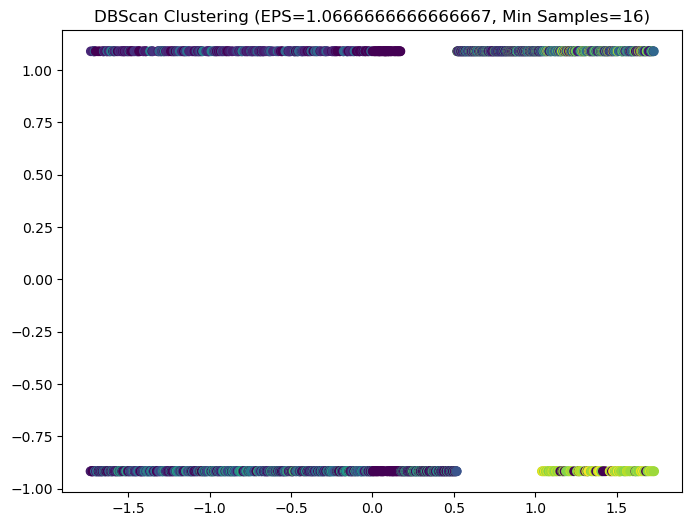

EPS: 1.0666666666666667, Min Samples: 16, Silhouette Score: 0.1951362119478888


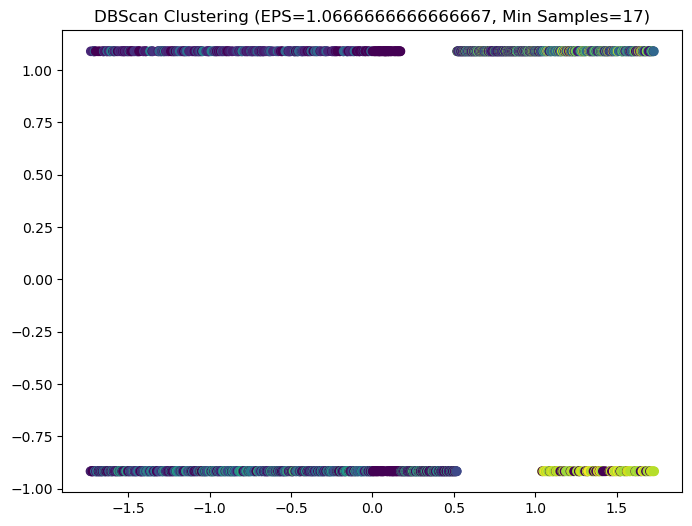

EPS: 1.0666666666666667, Min Samples: 17, Silhouette Score: 0.1798875562180438


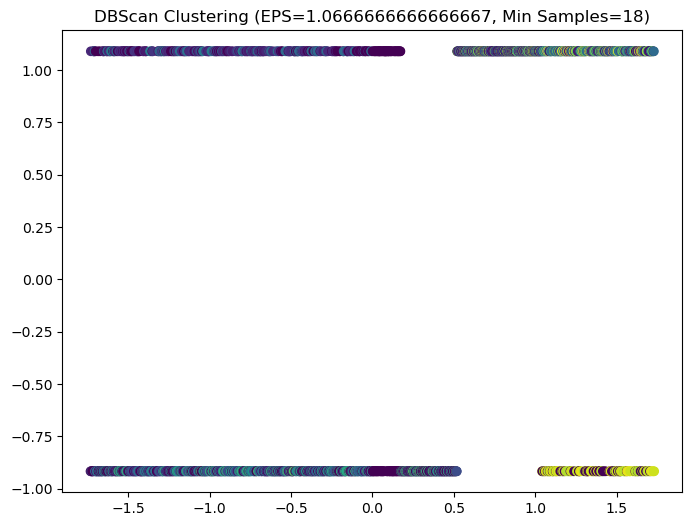

EPS: 1.0666666666666667, Min Samples: 18, Silhouette Score: 0.16741152414977847


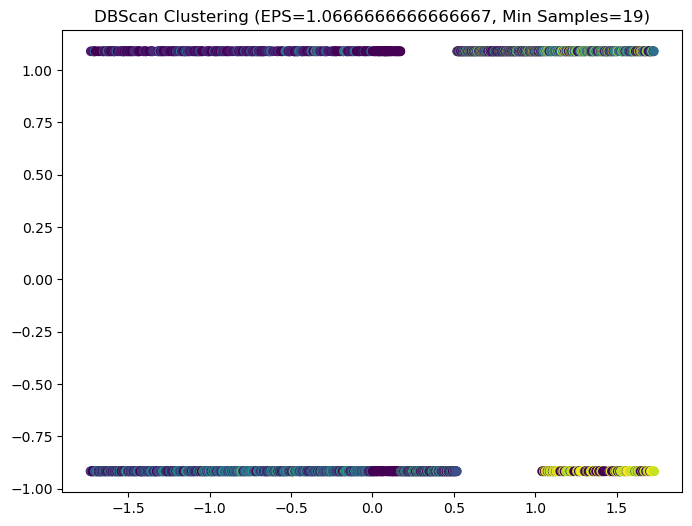

EPS: 1.0666666666666667, Min Samples: 19, Silhouette Score: 0.15540775311969696


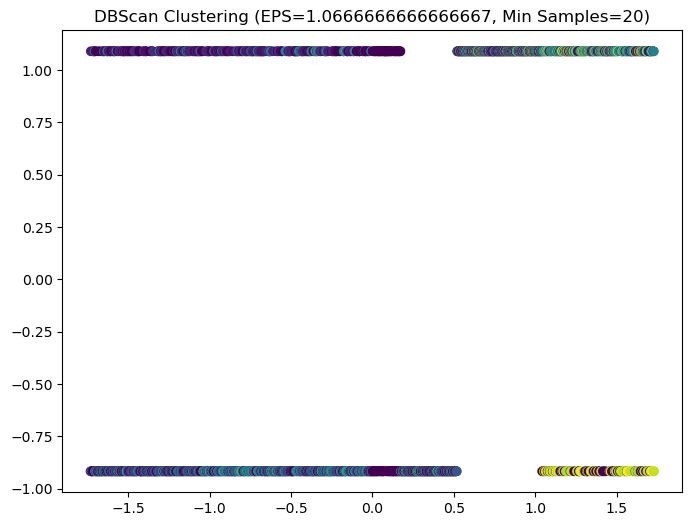

EPS: 1.0666666666666667, Min Samples: 20, Silhouette Score: 0.13955263517775998


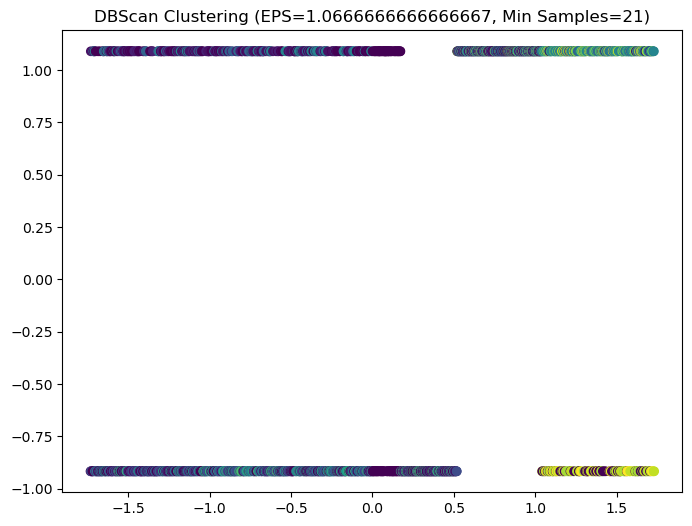

EPS: 1.0666666666666667, Min Samples: 21, Silhouette Score: 0.13981809442715218


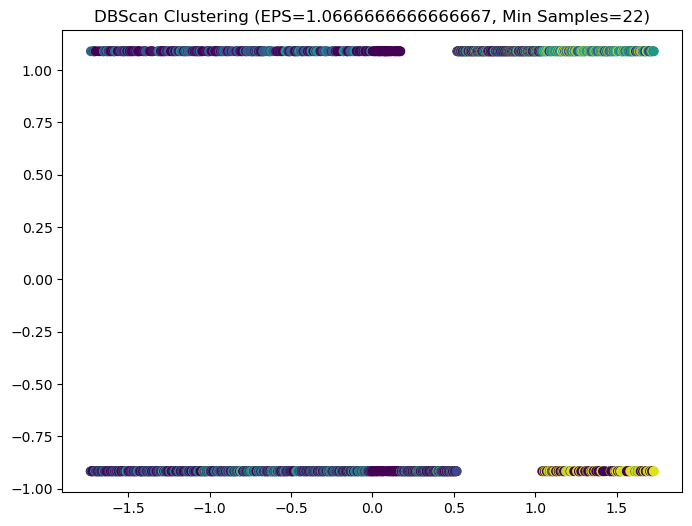

EPS: 1.0666666666666667, Min Samples: 22, Silhouette Score: 0.11082067936587921


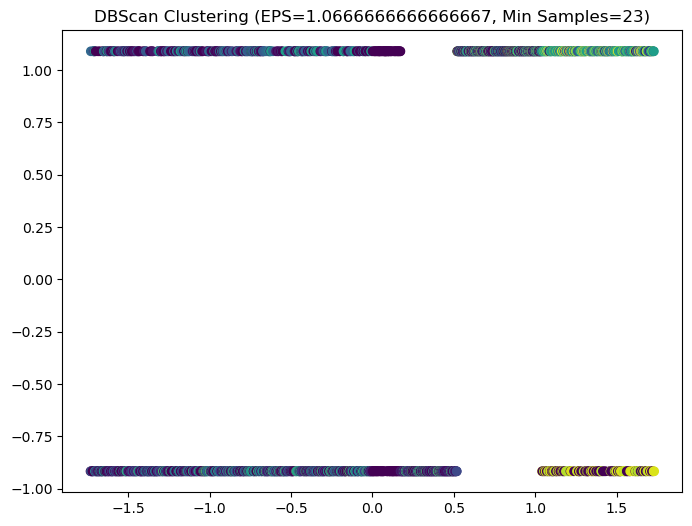

EPS: 1.0666666666666667, Min Samples: 23, Silhouette Score: 0.10949214384172382


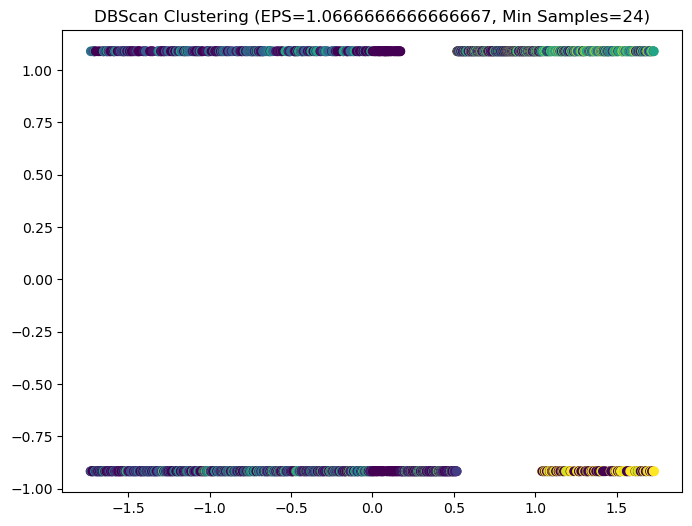

EPS: 1.0666666666666667, Min Samples: 24, Silhouette Score: 0.09230647050381918


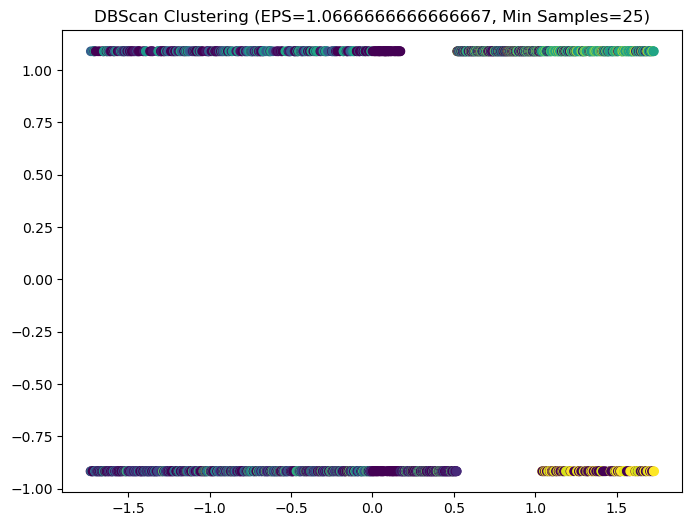

EPS: 1.0666666666666667, Min Samples: 25, Silhouette Score: 0.09019525753110441


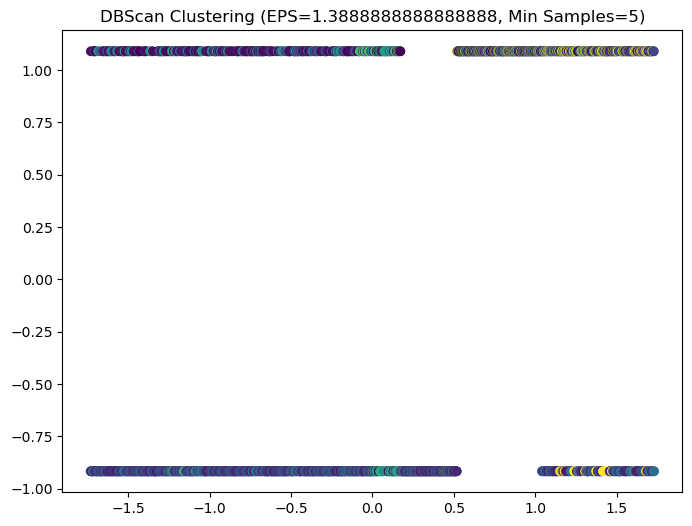

EPS: 1.3888888888888888, Min Samples: 5, Silhouette Score: 0.24539200662946625


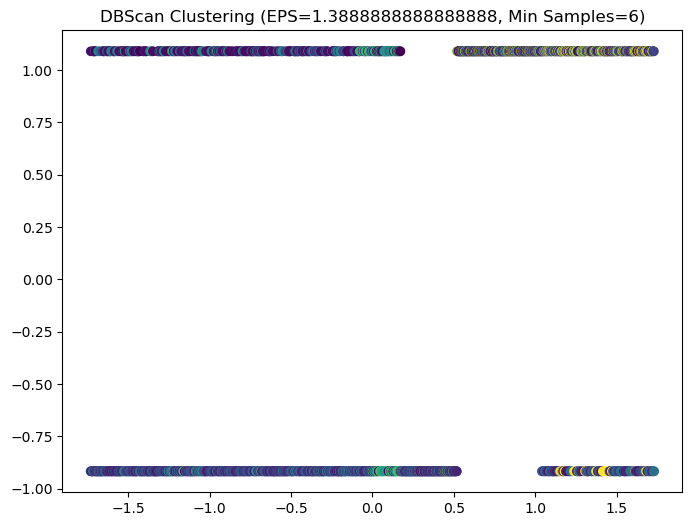

EPS: 1.3888888888888888, Min Samples: 6, Silhouette Score: 0.24356006441173977


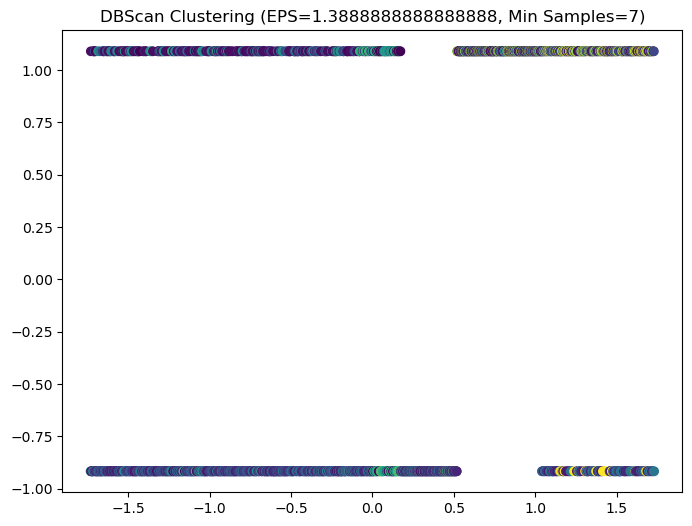

EPS: 1.3888888888888888, Min Samples: 7, Silhouette Score: 0.24045152495494318


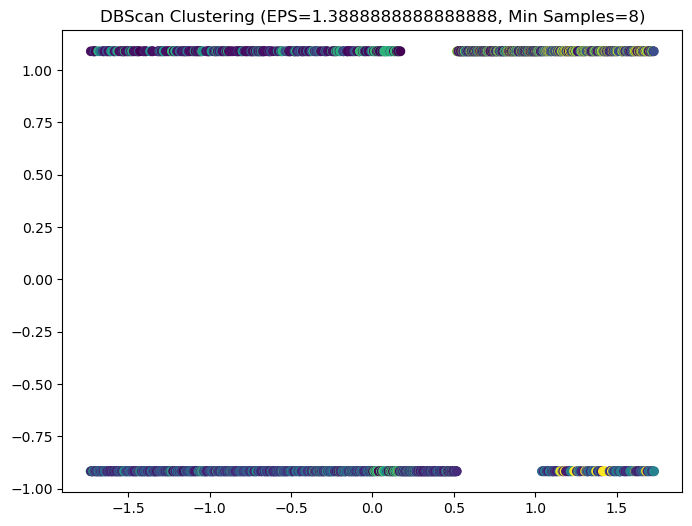

EPS: 1.3888888888888888, Min Samples: 8, Silhouette Score: 0.23381894231924624


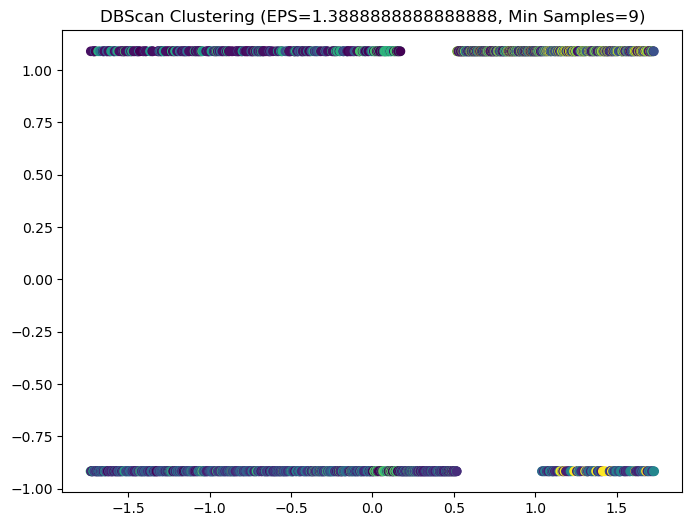

EPS: 1.3888888888888888, Min Samples: 9, Silhouette Score: 0.23304942047238467


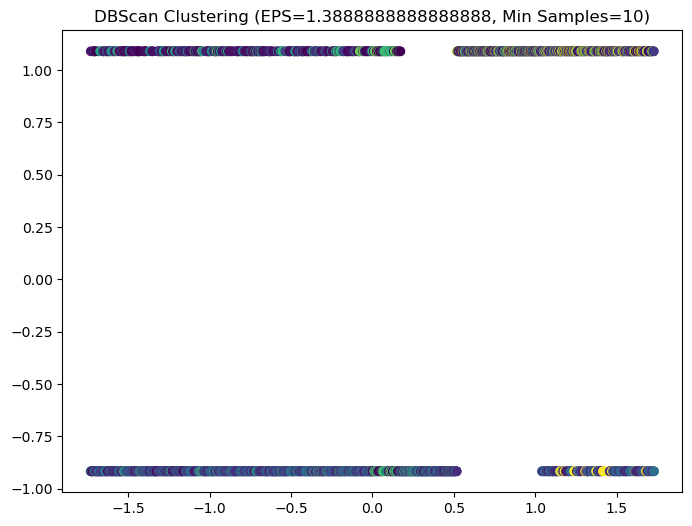

EPS: 1.3888888888888888, Min Samples: 10, Silhouette Score: 0.22266855979774056


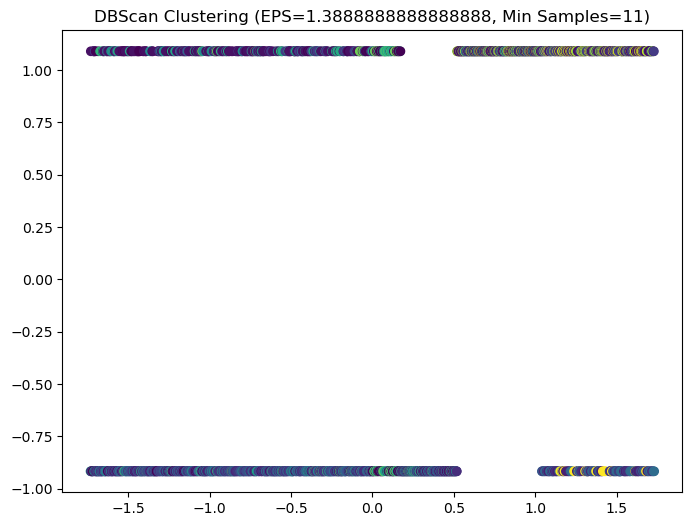

EPS: 1.3888888888888888, Min Samples: 11, Silhouette Score: 0.21776806571271579


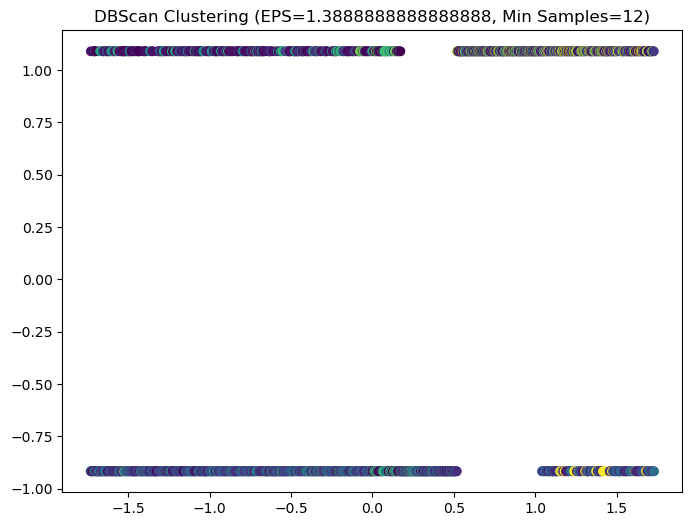

EPS: 1.3888888888888888, Min Samples: 12, Silhouette Score: 0.21187796194550557


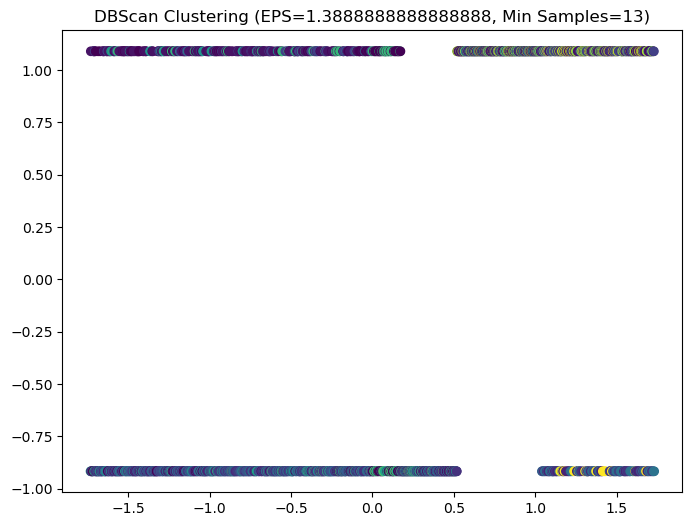

EPS: 1.3888888888888888, Min Samples: 13, Silhouette Score: 0.21231726181576568


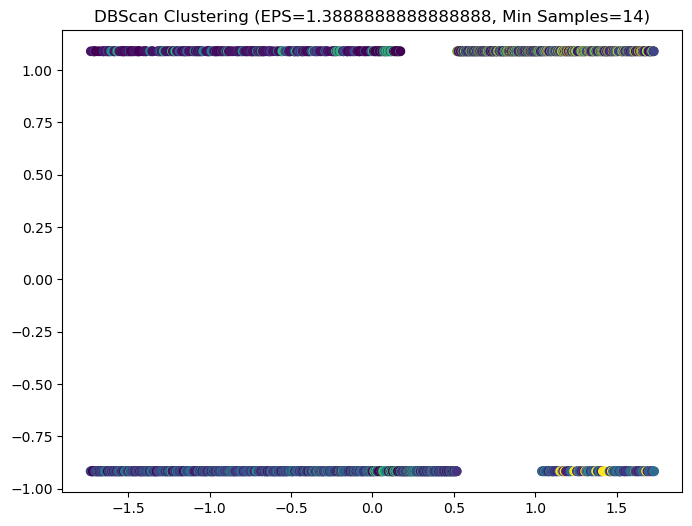

EPS: 1.3888888888888888, Min Samples: 14, Silhouette Score: 0.2055999432019213


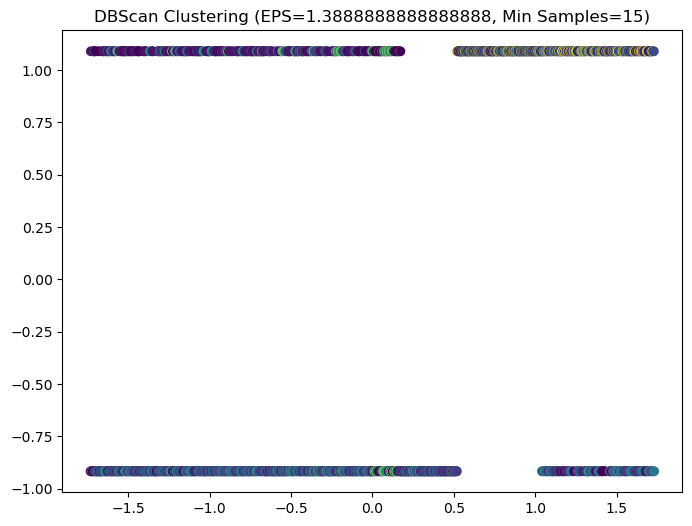

EPS: 1.3888888888888888, Min Samples: 15, Silhouette Score: 0.2013124011153707


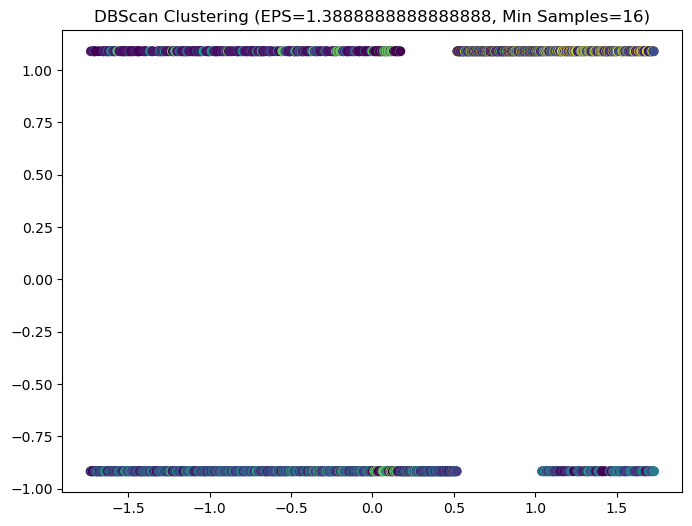

EPS: 1.3888888888888888, Min Samples: 16, Silhouette Score: 0.19323732122125387


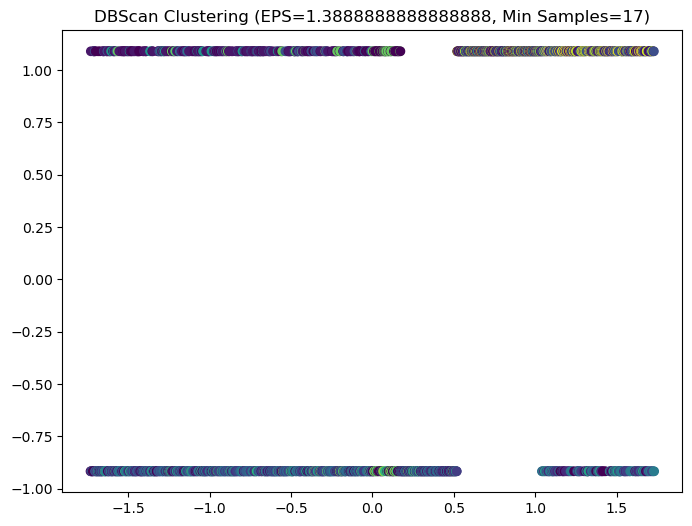

EPS: 1.3888888888888888, Min Samples: 17, Silhouette Score: 0.19109447076233982


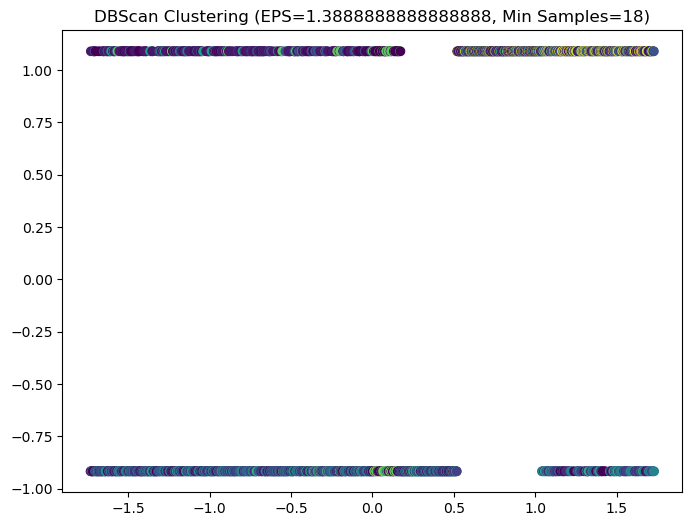

EPS: 1.3888888888888888, Min Samples: 18, Silhouette Score: 0.19118282876148668


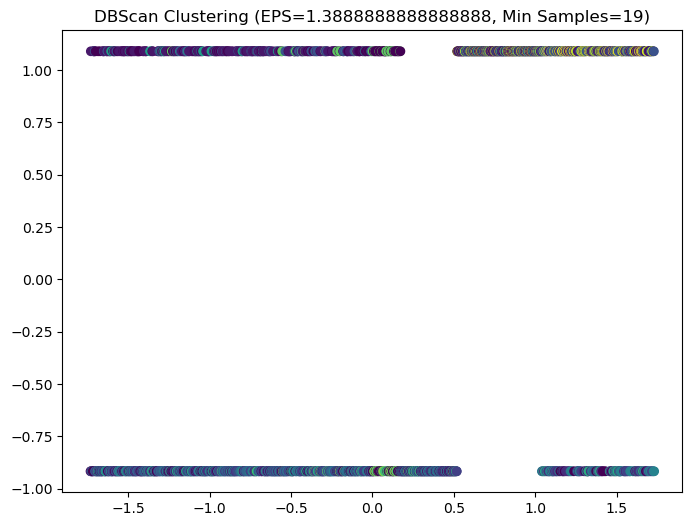

EPS: 1.3888888888888888, Min Samples: 19, Silhouette Score: 0.18981235637089744


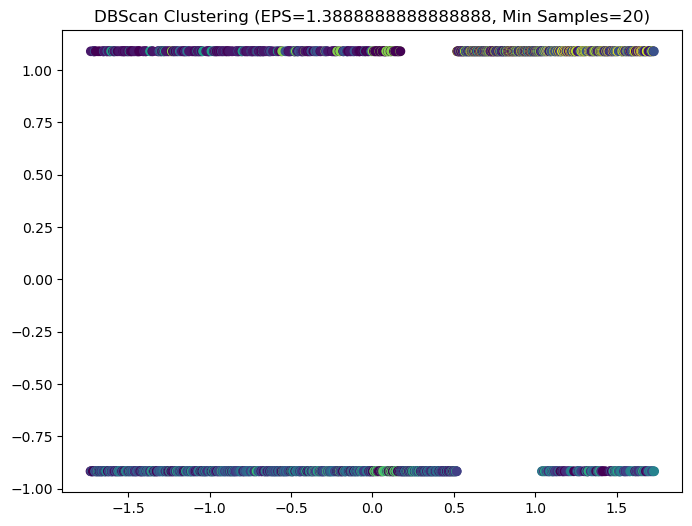

EPS: 1.3888888888888888, Min Samples: 20, Silhouette Score: 0.18815174140781307


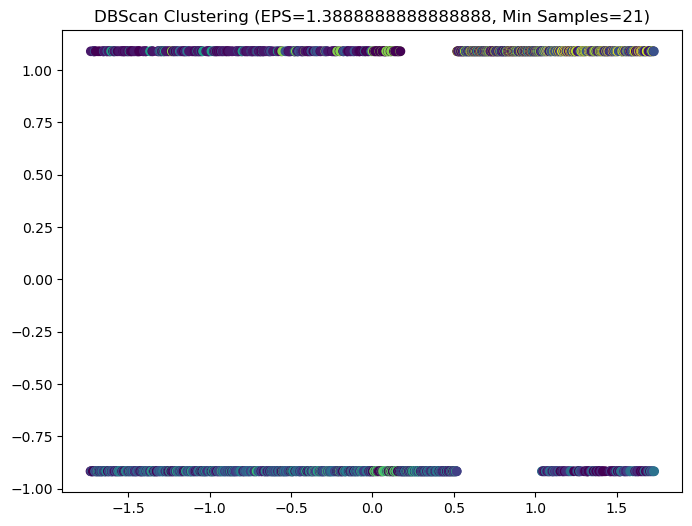

EPS: 1.3888888888888888, Min Samples: 21, Silhouette Score: 0.17545519169556575


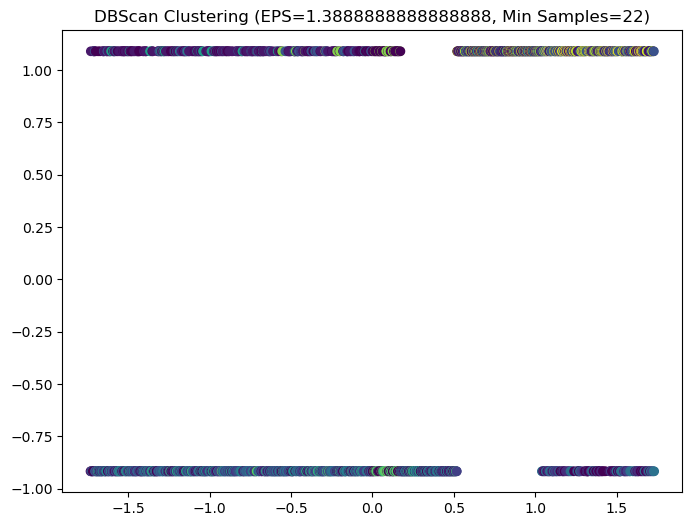

EPS: 1.3888888888888888, Min Samples: 22, Silhouette Score: 0.16994159164725023


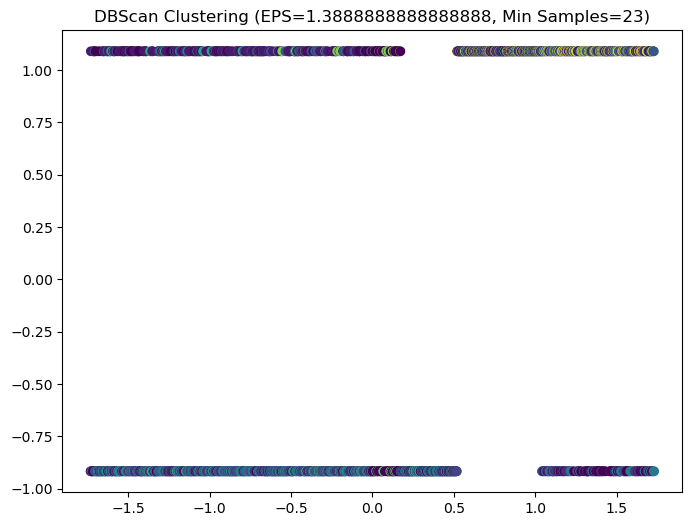

EPS: 1.3888888888888888, Min Samples: 23, Silhouette Score: 0.16271794937351214


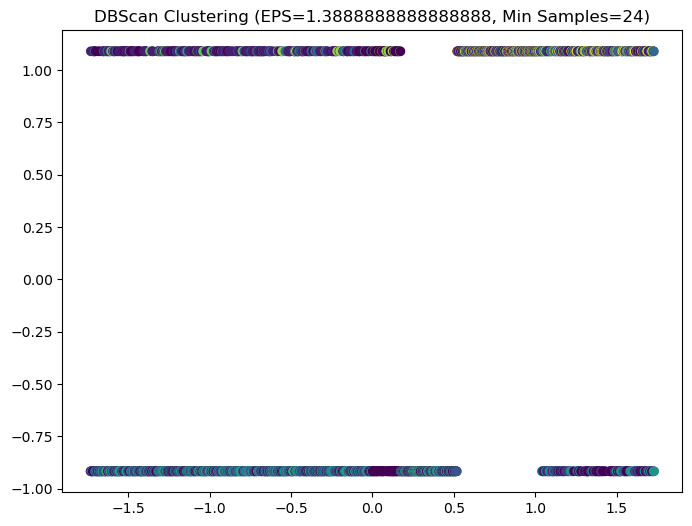

EPS: 1.3888888888888888, Min Samples: 24, Silhouette Score: 0.1433752576288117


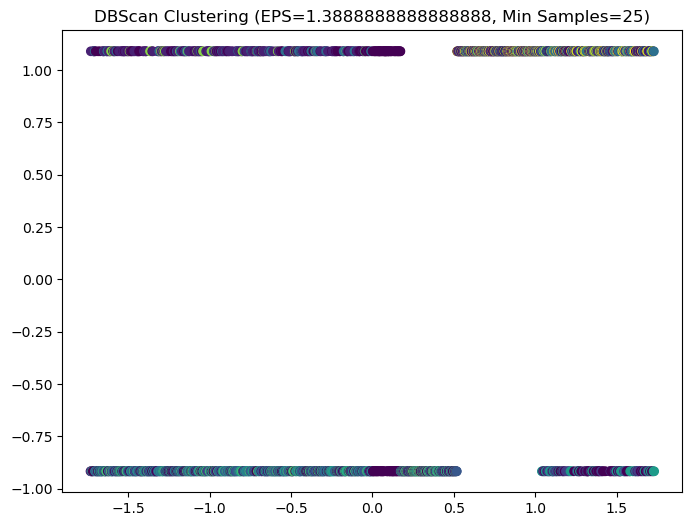

EPS: 1.3888888888888888, Min Samples: 25, Silhouette Score: 0.1496636853659998


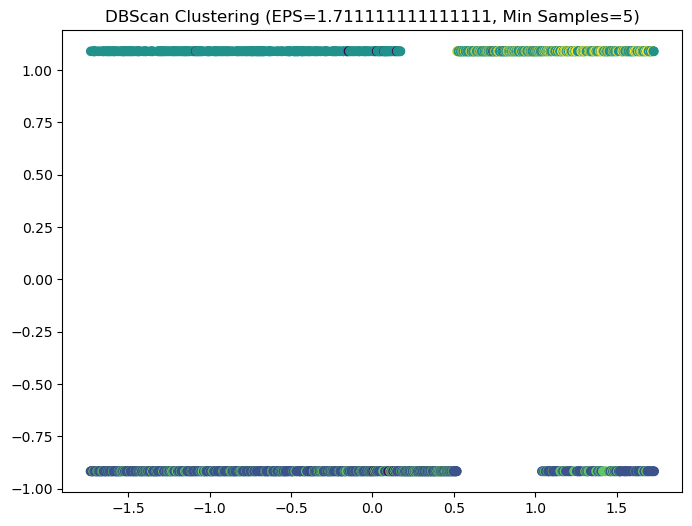

EPS: 1.711111111111111, Min Samples: 5, Silhouette Score: 0.13743963402905665


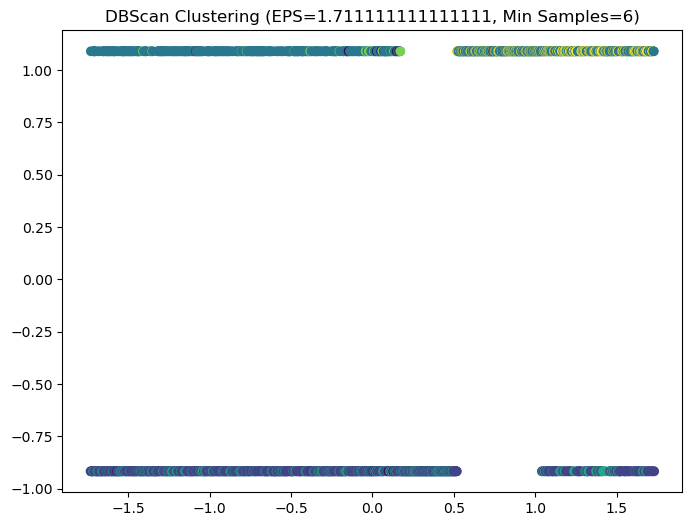

EPS: 1.711111111111111, Min Samples: 6, Silhouette Score: 0.13995599033516767


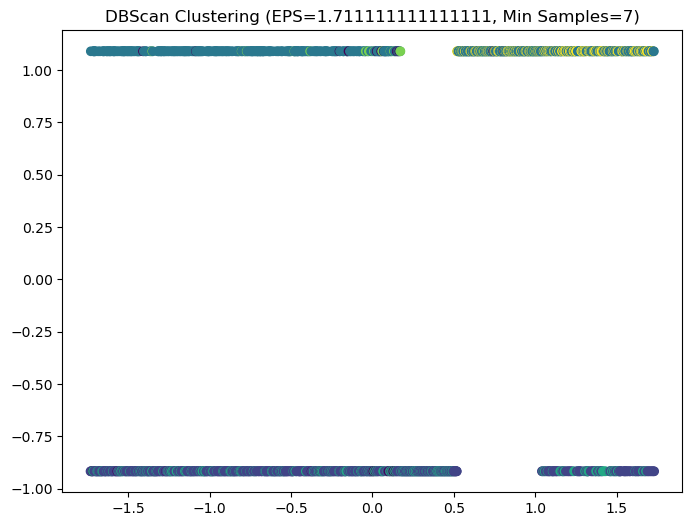

EPS: 1.711111111111111, Min Samples: 7, Silhouette Score: 0.13805541466240606


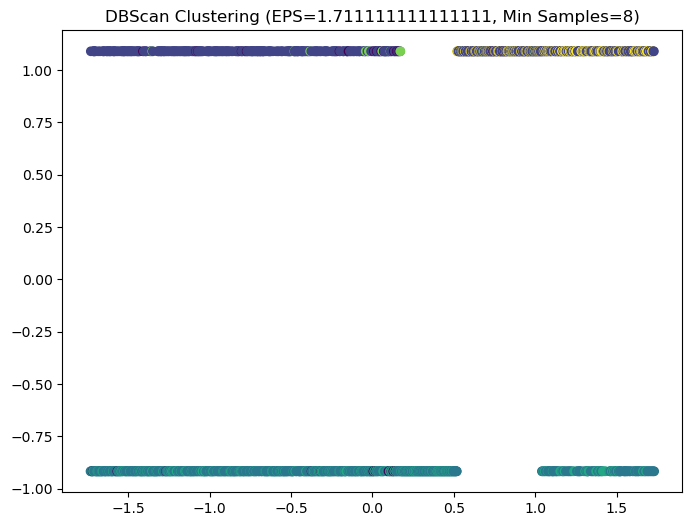

EPS: 1.711111111111111, Min Samples: 8, Silhouette Score: 0.13358181107688644


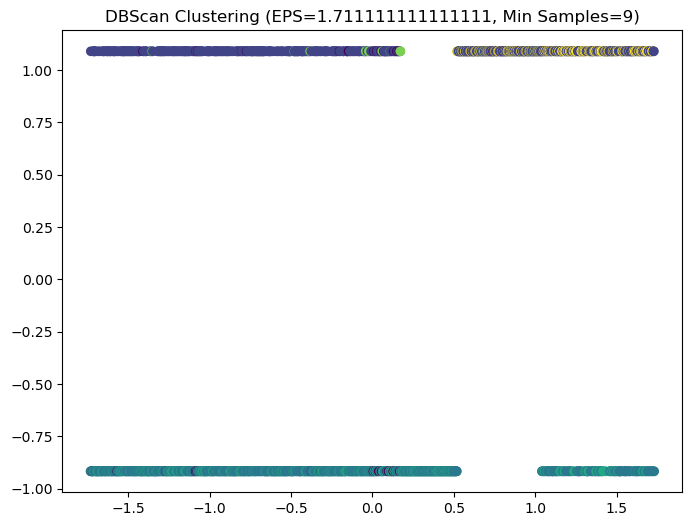

EPS: 1.711111111111111, Min Samples: 9, Silhouette Score: 0.135384879084952


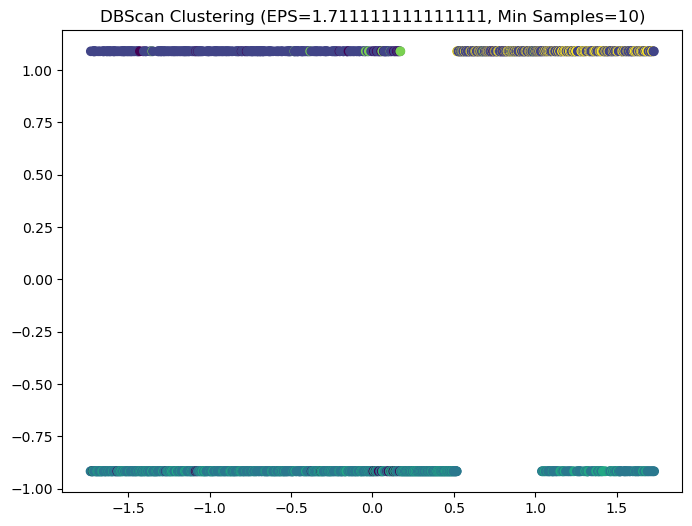

EPS: 1.711111111111111, Min Samples: 10, Silhouette Score: 0.13564130409167055


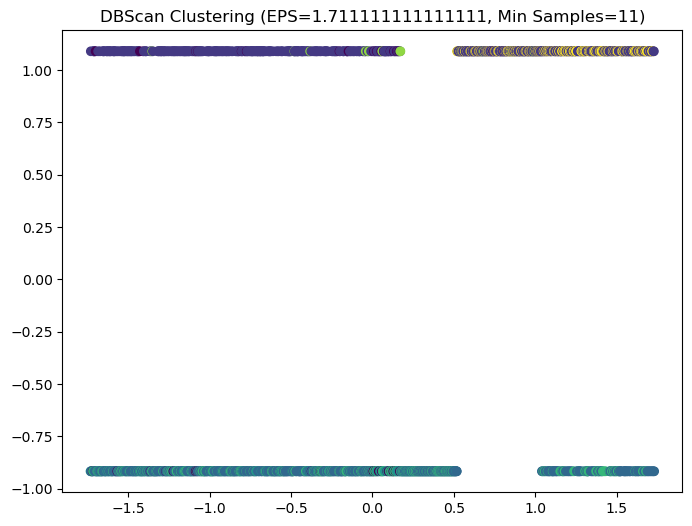

EPS: 1.711111111111111, Min Samples: 11, Silhouette Score: 0.1507429747219925


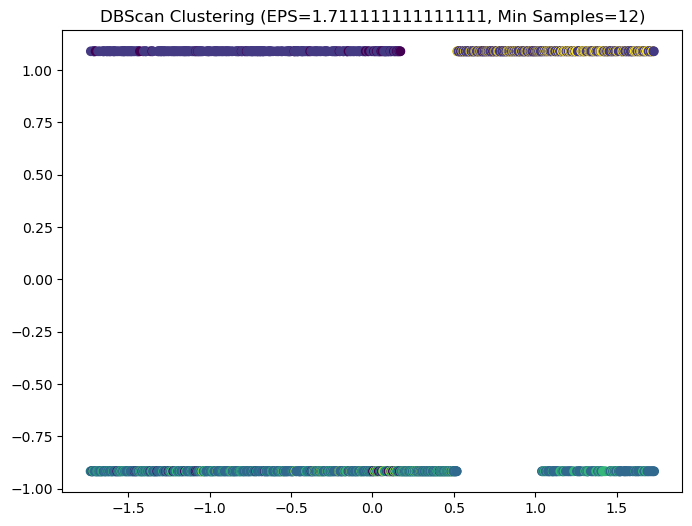

EPS: 1.711111111111111, Min Samples: 12, Silhouette Score: 0.13425219359640825


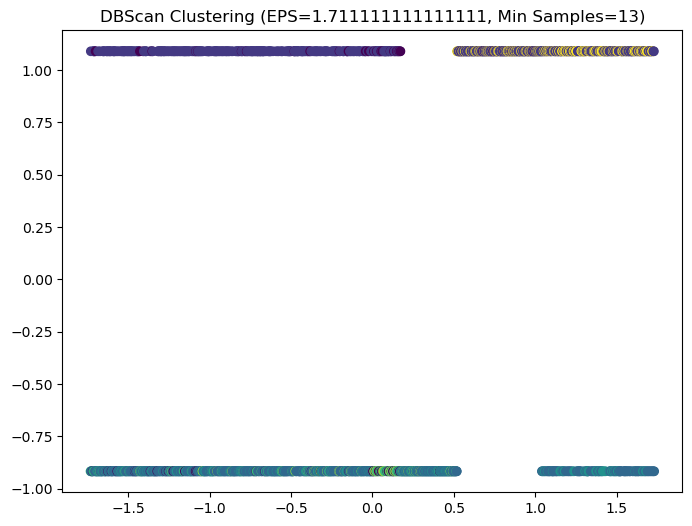

EPS: 1.711111111111111, Min Samples: 13, Silhouette Score: 0.13384014138523617


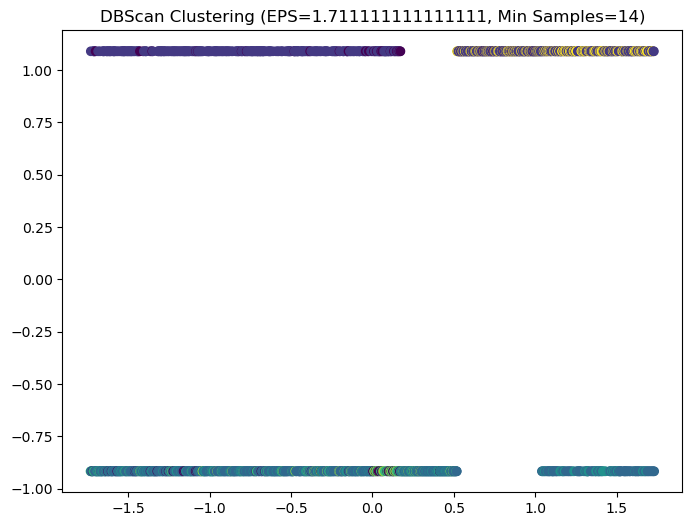

EPS: 1.711111111111111, Min Samples: 14, Silhouette Score: 0.132435711107292


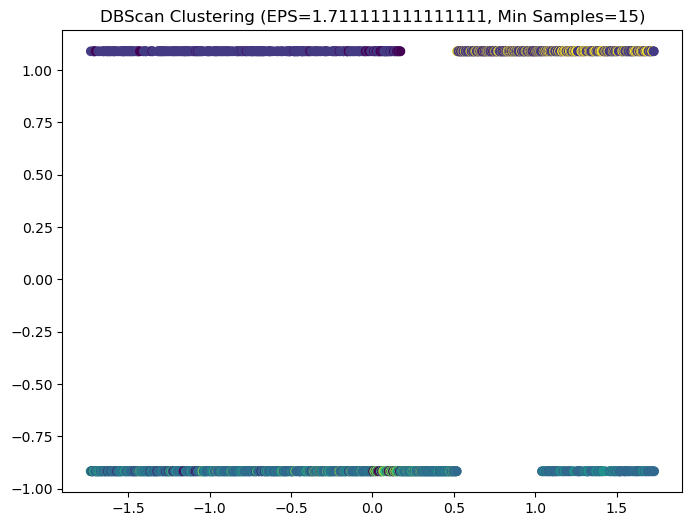

EPS: 1.711111111111111, Min Samples: 15, Silhouette Score: 0.13340457390415258


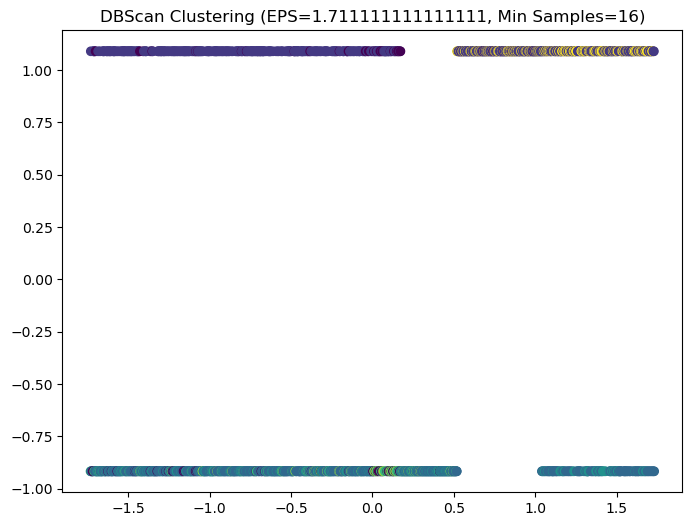

EPS: 1.711111111111111, Min Samples: 16, Silhouette Score: 0.13283005212987015


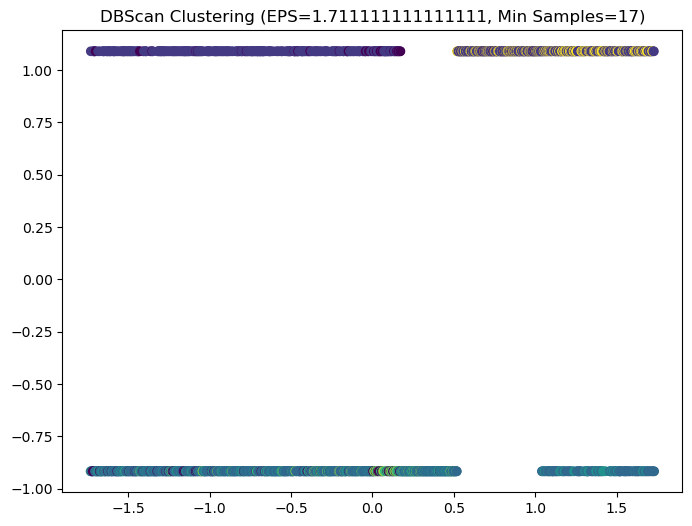

EPS: 1.711111111111111, Min Samples: 17, Silhouette Score: 0.12607209920552118


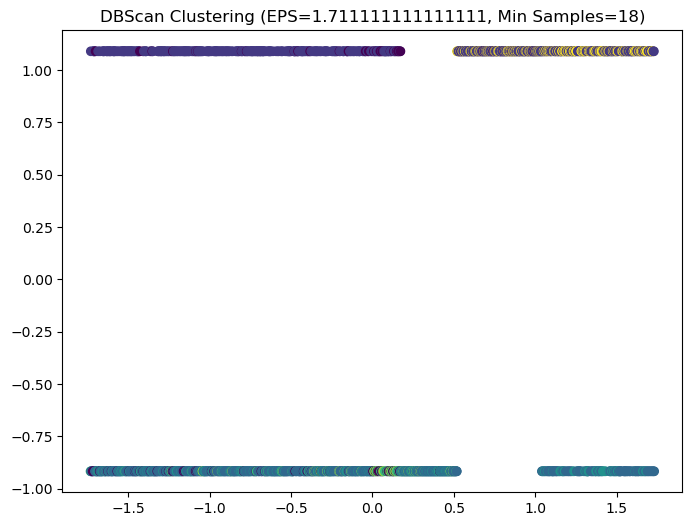

EPS: 1.711111111111111, Min Samples: 18, Silhouette Score: 0.12510898587279906


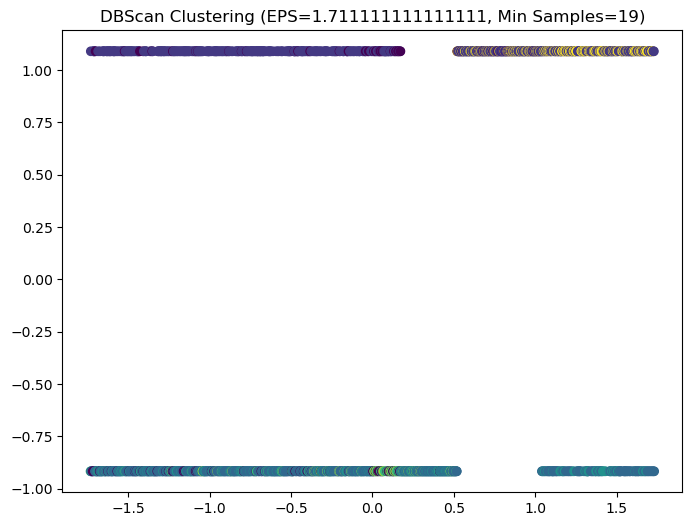

EPS: 1.711111111111111, Min Samples: 19, Silhouette Score: 0.11989176473268989


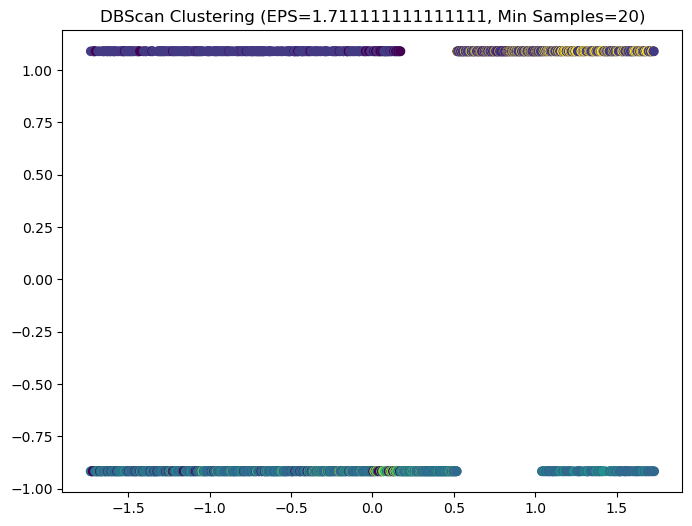

EPS: 1.711111111111111, Min Samples: 20, Silhouette Score: 0.11996431030533454


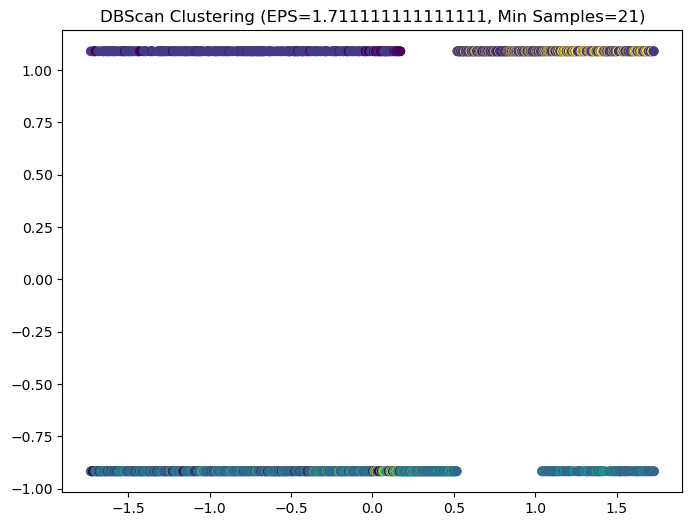

EPS: 1.711111111111111, Min Samples: 21, Silhouette Score: 0.11791831361387935


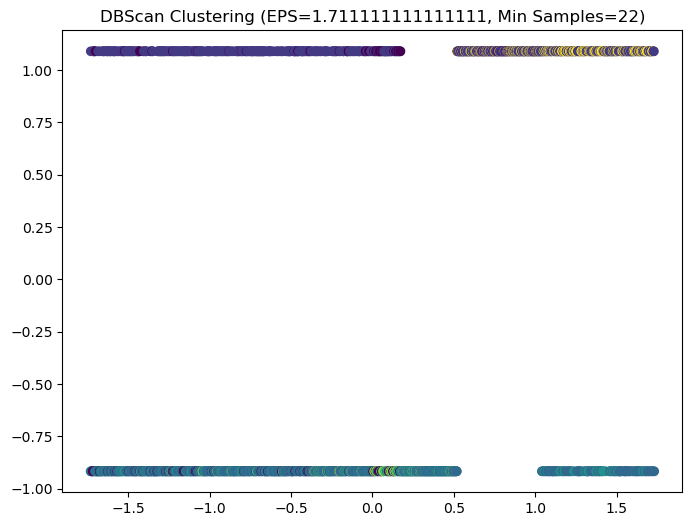

EPS: 1.711111111111111, Min Samples: 22, Silhouette Score: 0.11833042347003823


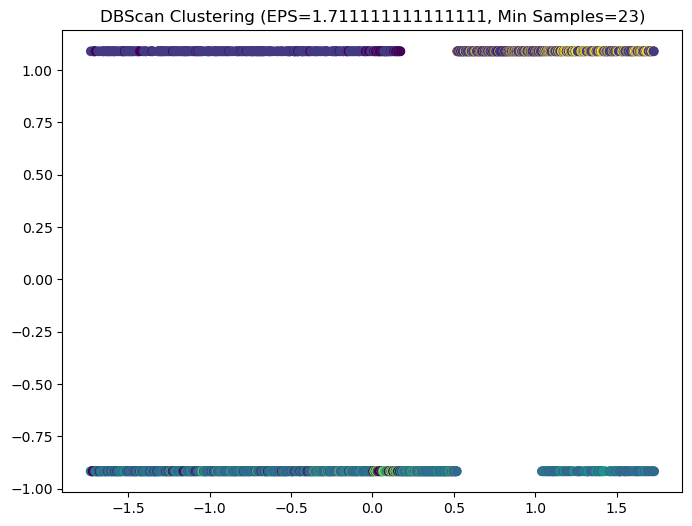

EPS: 1.711111111111111, Min Samples: 23, Silhouette Score: 0.1166937295685913


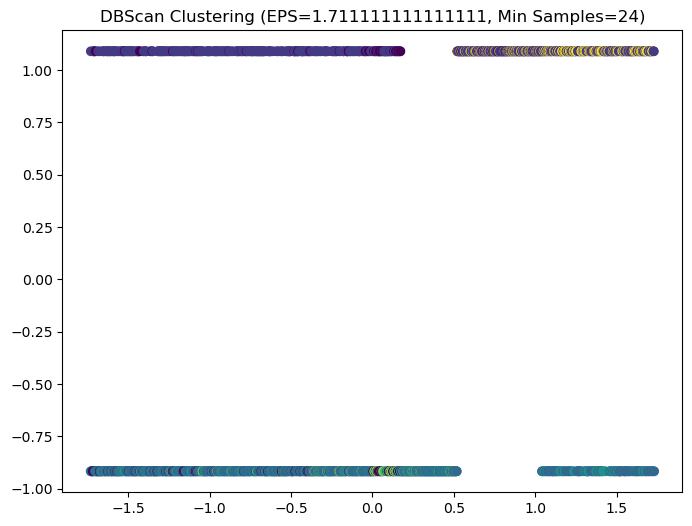

EPS: 1.711111111111111, Min Samples: 24, Silhouette Score: 0.1166937295685913


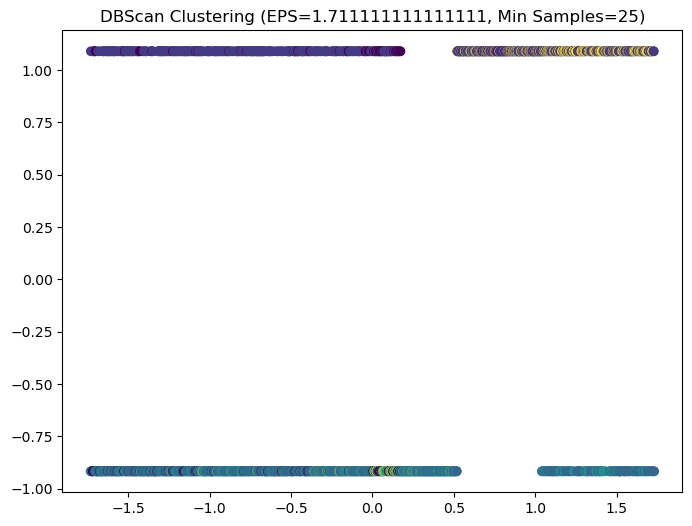

EPS: 1.711111111111111, Min Samples: 25, Silhouette Score: 0.11651231456180684


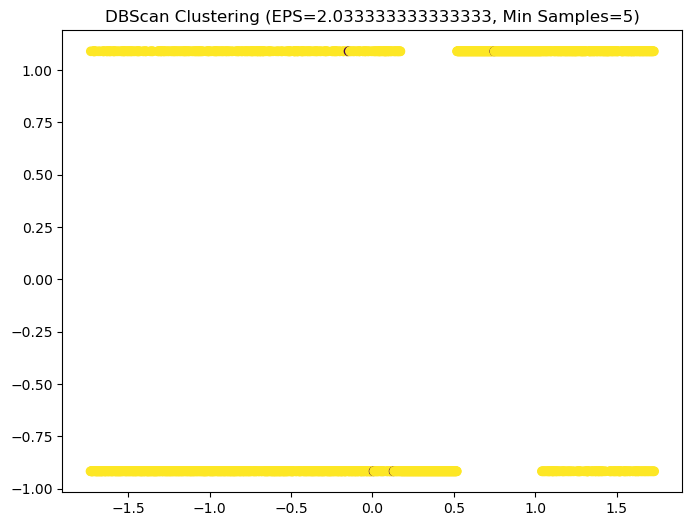

EPS: 2.033333333333333, Min Samples: 5, Silhouette Score: 0.333517430284198


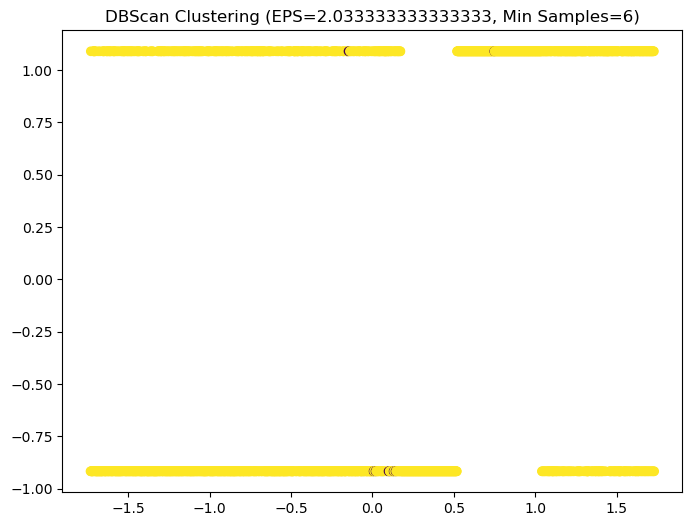

EPS: 2.033333333333333, Min Samples: 6, Silhouette Score: 0.2993805122366857


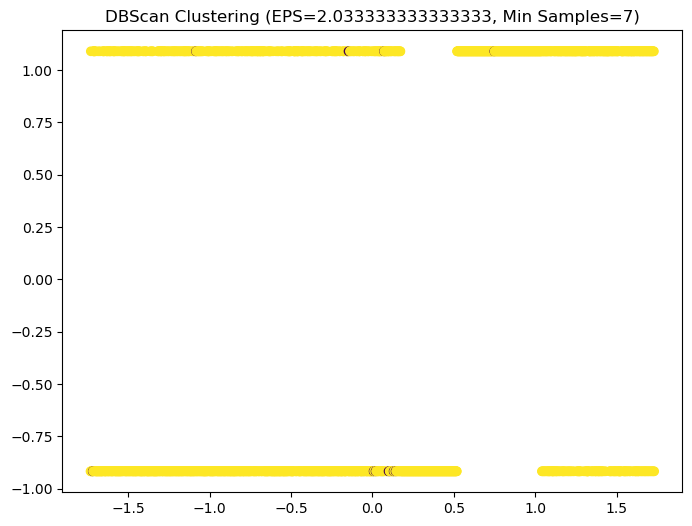

EPS: 2.033333333333333, Min Samples: 7, Silhouette Score: 0.31887589434290126


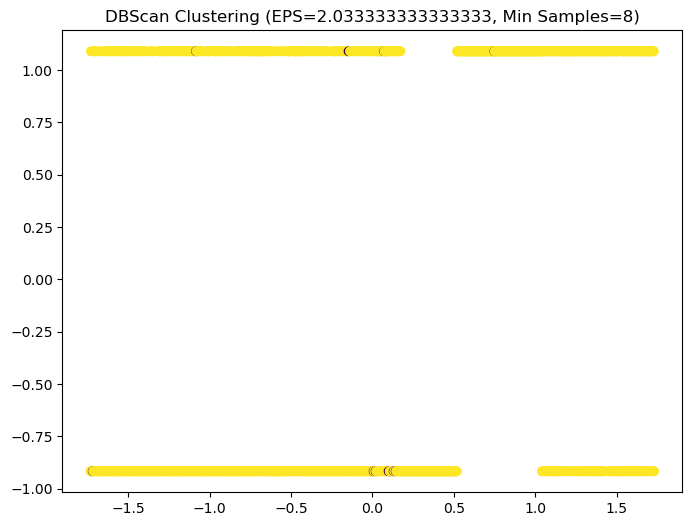

EPS: 2.033333333333333, Min Samples: 8, Silhouette Score: 0.31887589434290126


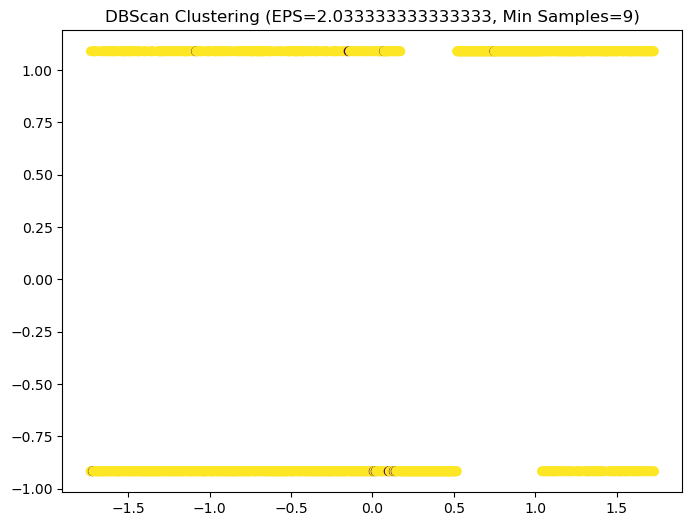

EPS: 2.033333333333333, Min Samples: 9, Silhouette Score: 0.31887589434290126


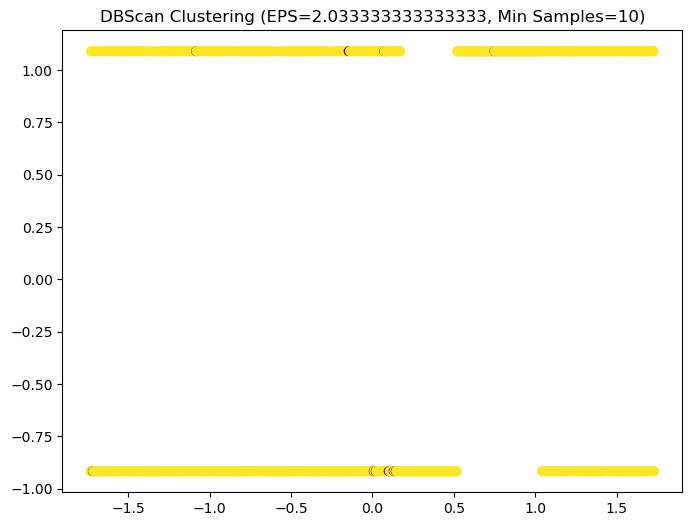

EPS: 2.033333333333333, Min Samples: 10, Silhouette Score: 0.31887589434290126


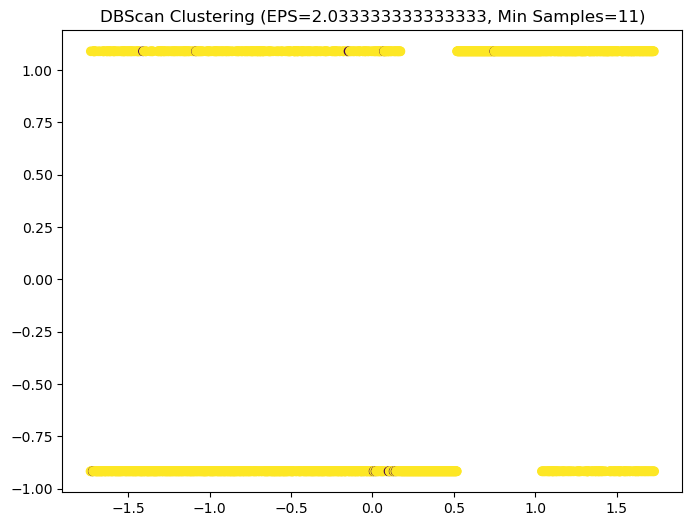

EPS: 2.033333333333333, Min Samples: 11, Silhouette Score: 0.3256103252157393


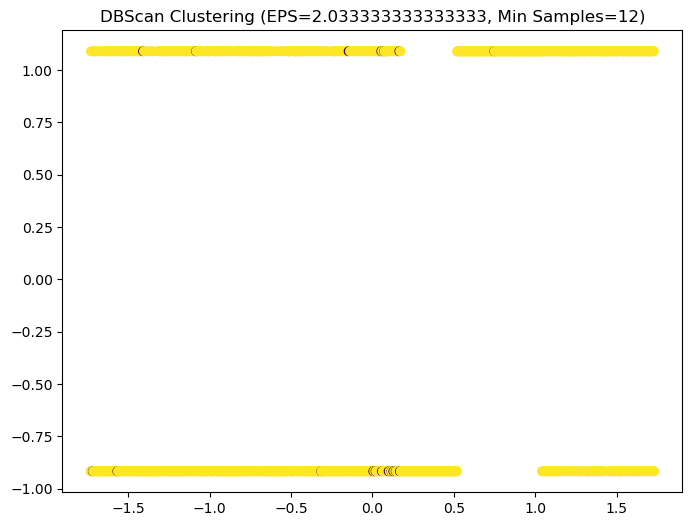

EPS: 2.033333333333333, Min Samples: 12, Silhouette Score: 0.3189014096398098


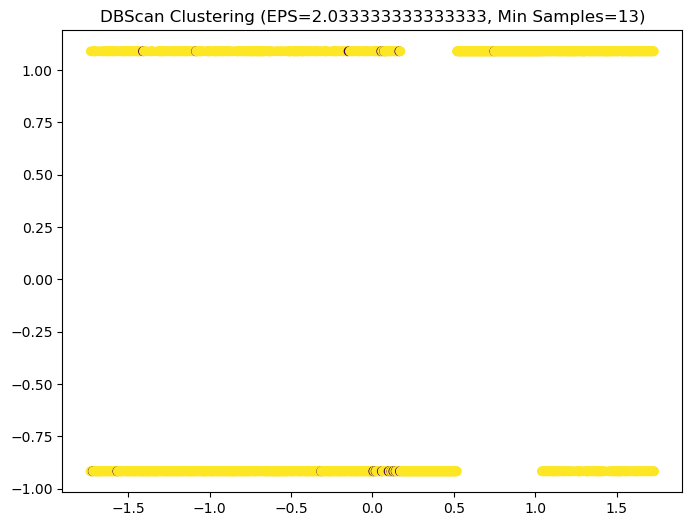

EPS: 2.033333333333333, Min Samples: 13, Silhouette Score: 0.3189014096398098


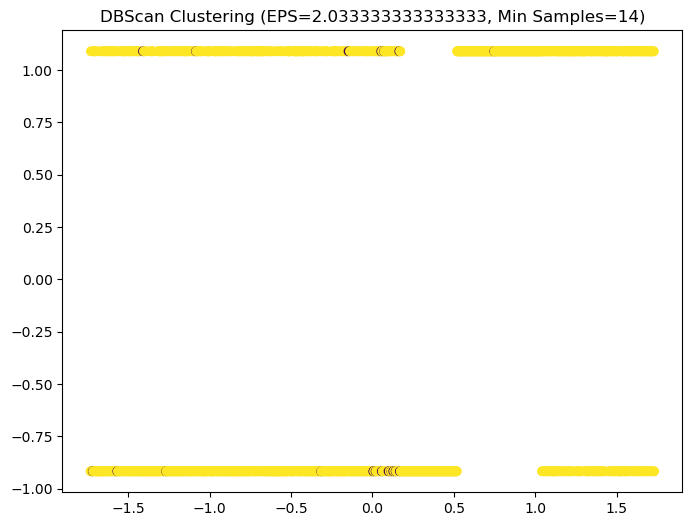

EPS: 2.033333333333333, Min Samples: 14, Silhouette Score: 0.3153153779907248


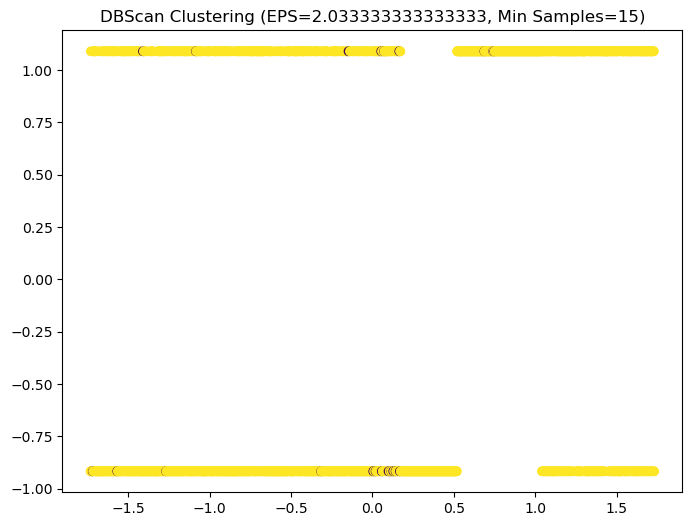

EPS: 2.033333333333333, Min Samples: 15, Silhouette Score: 0.3144547176174211


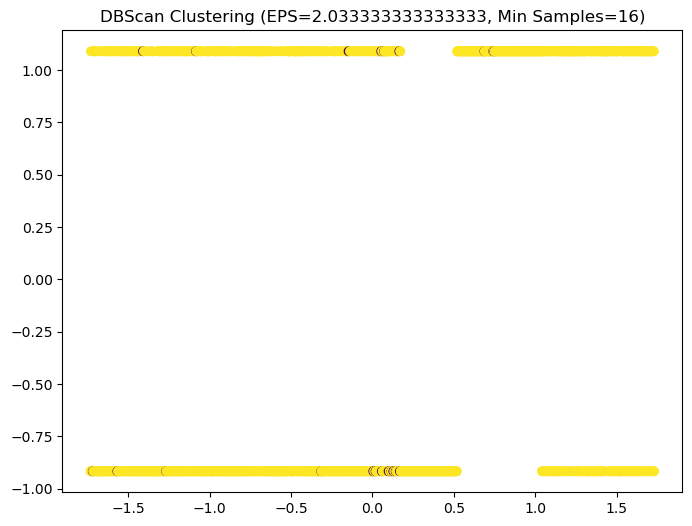

EPS: 2.033333333333333, Min Samples: 16, Silhouette Score: 0.3144547176174211


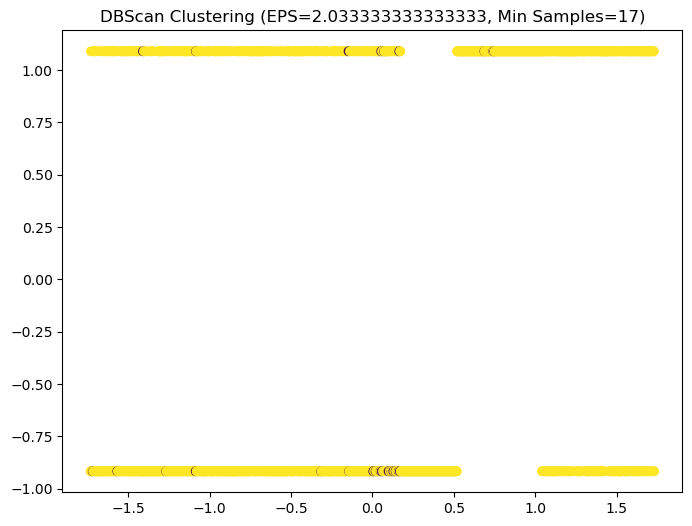

EPS: 2.033333333333333, Min Samples: 17, Silhouette Score: 0.33090803374606437


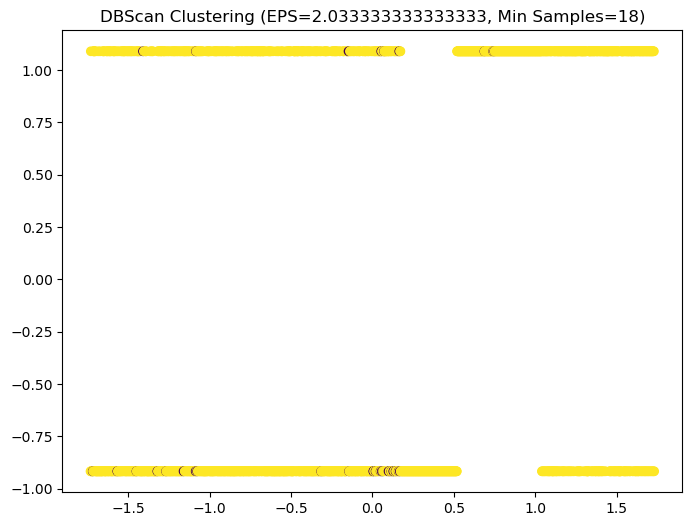

EPS: 2.033333333333333, Min Samples: 18, Silhouette Score: 0.3288435055124418


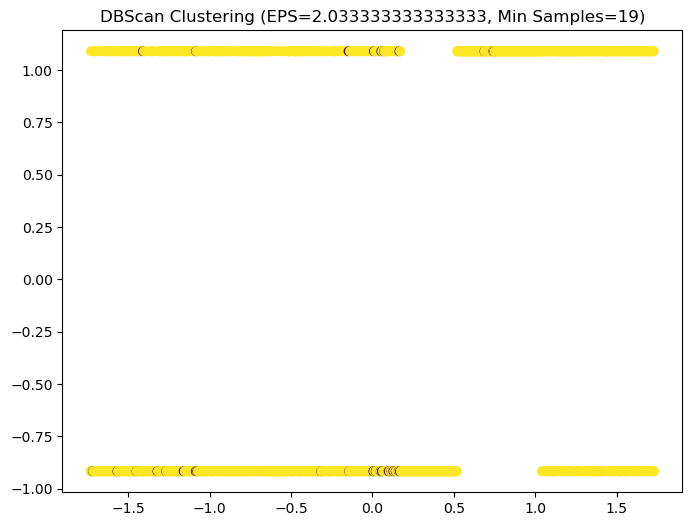

EPS: 2.033333333333333, Min Samples: 19, Silhouette Score: 0.3309068131364975


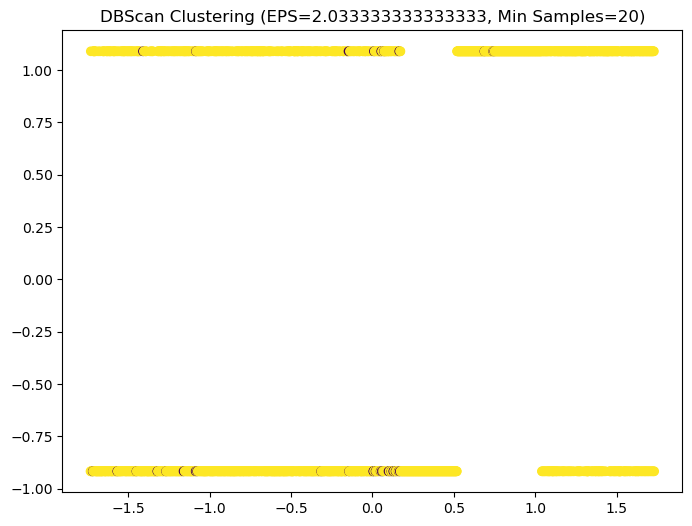

EPS: 2.033333333333333, Min Samples: 20, Silhouette Score: 0.3309068131364975


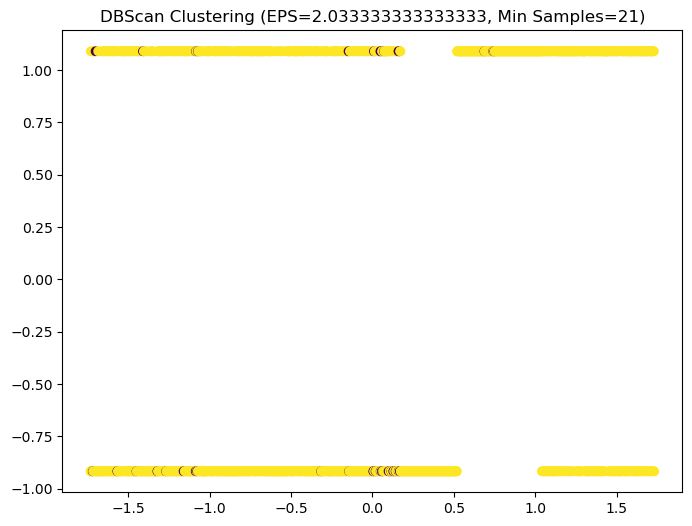

EPS: 2.033333333333333, Min Samples: 21, Silhouette Score: 0.3311632180306871


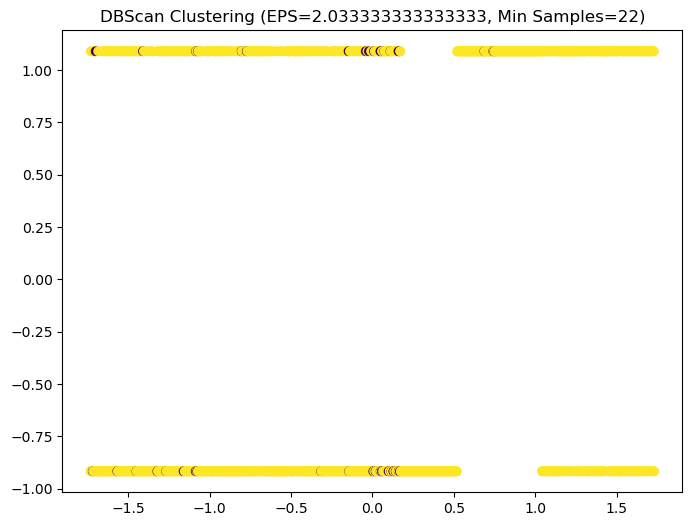

EPS: 2.033333333333333, Min Samples: 22, Silhouette Score: 0.33163617079301033


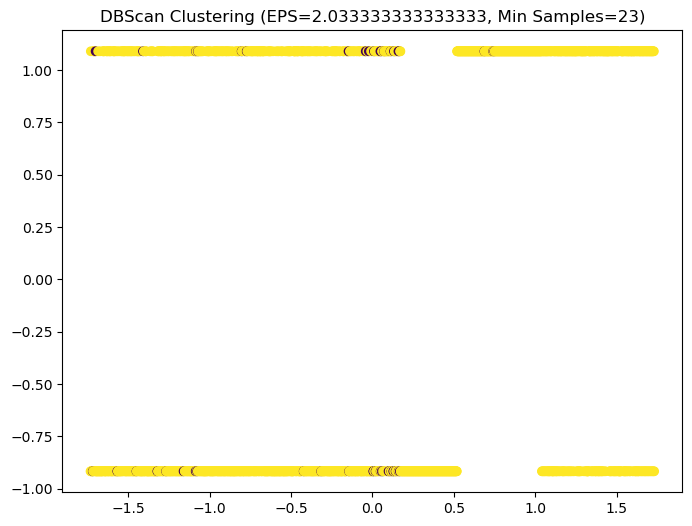

EPS: 2.033333333333333, Min Samples: 23, Silhouette Score: 0.33161362510995185


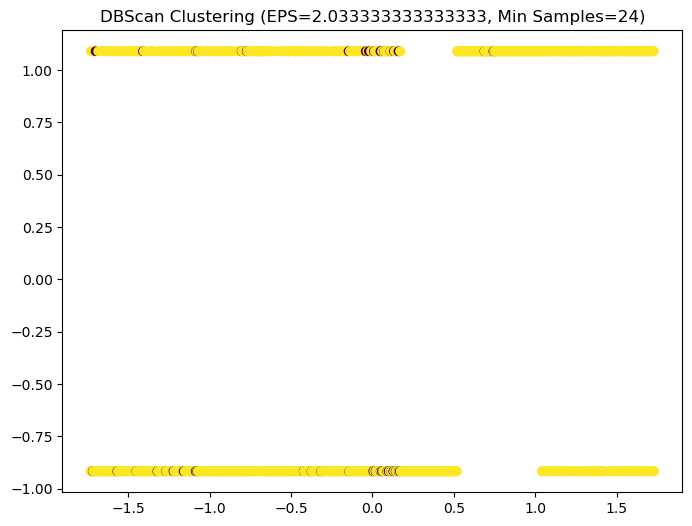

EPS: 2.033333333333333, Min Samples: 24, Silhouette Score: 0.32645450986000685


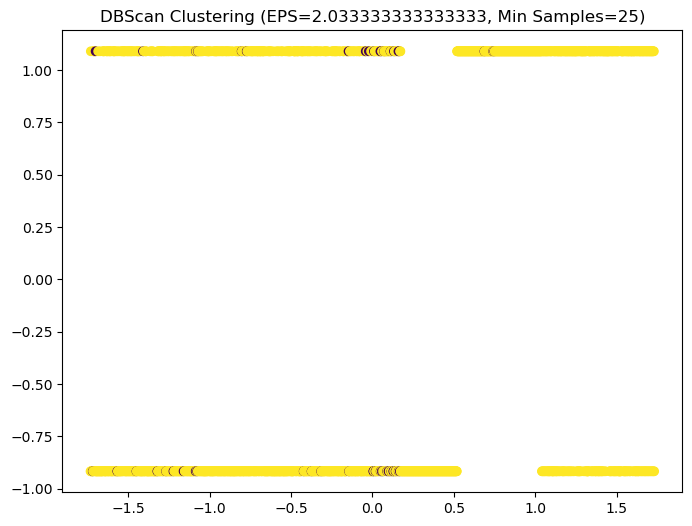

EPS: 2.033333333333333, Min Samples: 25, Silhouette Score: 0.32645450986000685


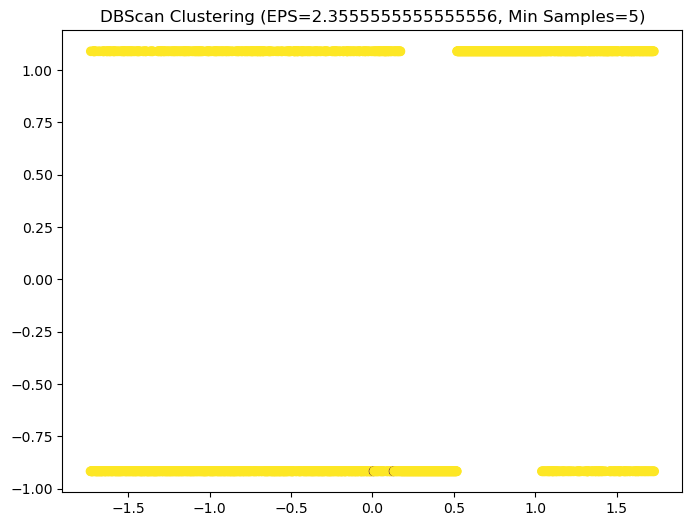

EPS: 2.3555555555555556, Min Samples: 5, Silhouette Score: 0.30991073468773084


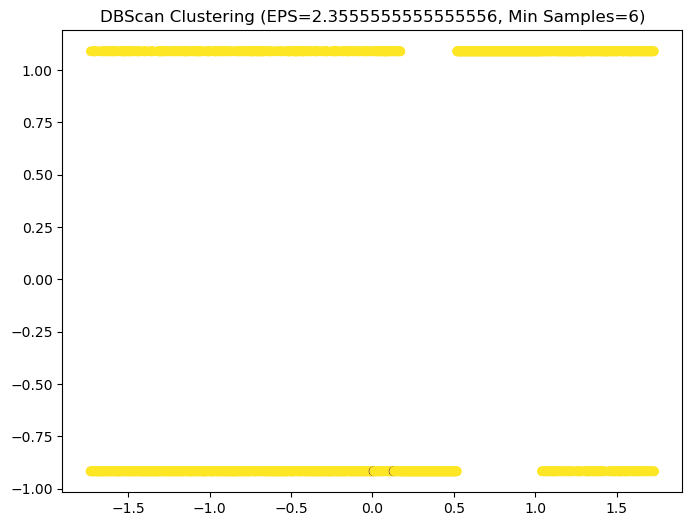

EPS: 2.3555555555555556, Min Samples: 6, Silhouette Score: 0.30991073468773084


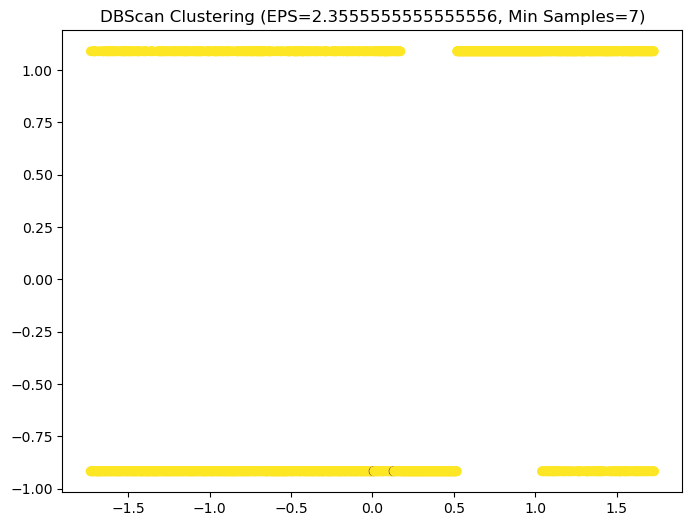

EPS: 2.3555555555555556, Min Samples: 7, Silhouette Score: 0.30991073468773084


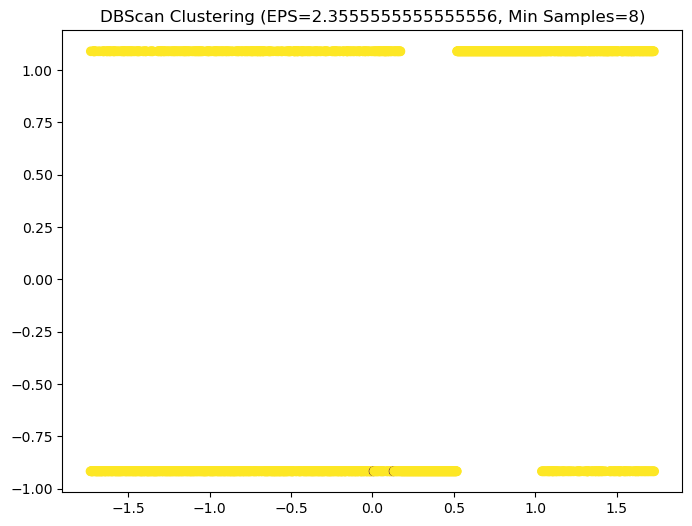

EPS: 2.3555555555555556, Min Samples: 8, Silhouette Score: 0.30991073468773084


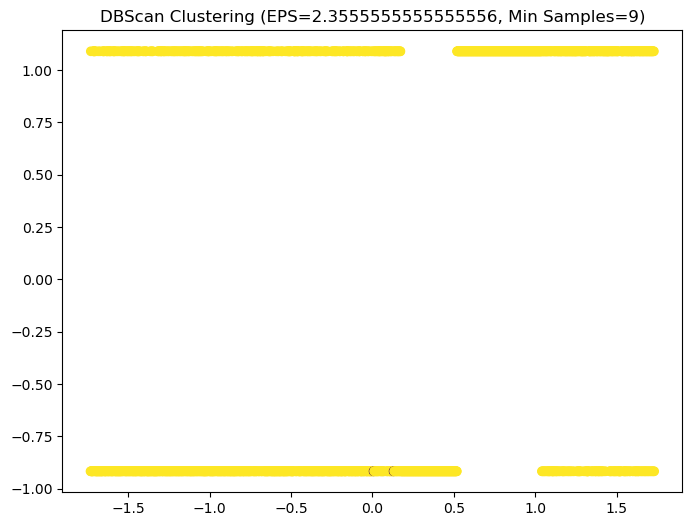

EPS: 2.3555555555555556, Min Samples: 9, Silhouette Score: 0.30991073468773084


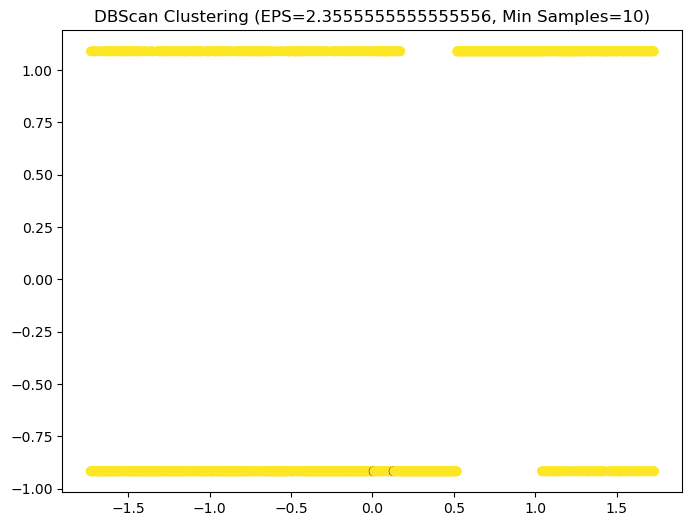

EPS: 2.3555555555555556, Min Samples: 10, Silhouette Score: 0.30991073468773084


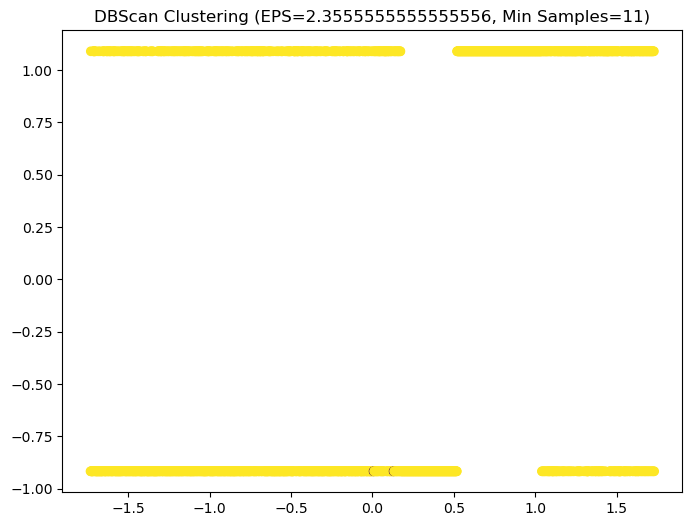

EPS: 2.3555555555555556, Min Samples: 11, Silhouette Score: 0.30991073468773084


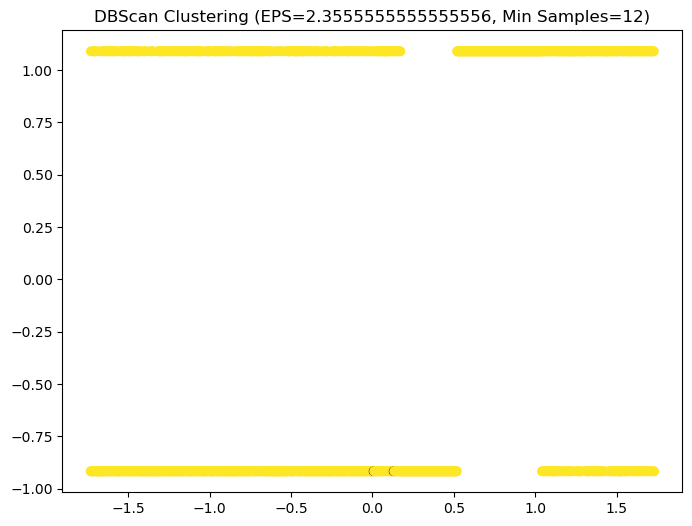

EPS: 2.3555555555555556, Min Samples: 12, Silhouette Score: 0.30991073468773084


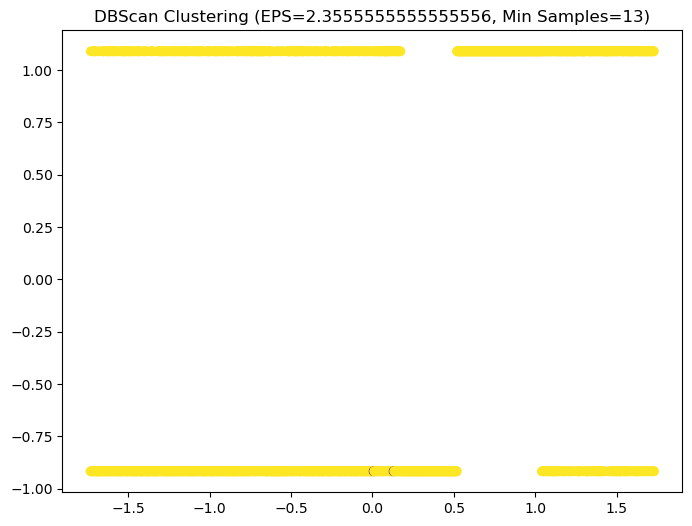

EPS: 2.3555555555555556, Min Samples: 13, Silhouette Score: 0.30991073468773084


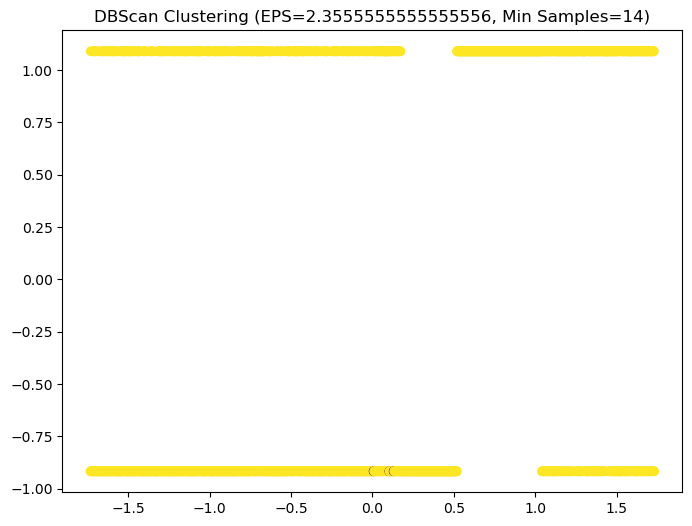

EPS: 2.3555555555555556, Min Samples: 14, Silhouette Score: 0.3152141323662188


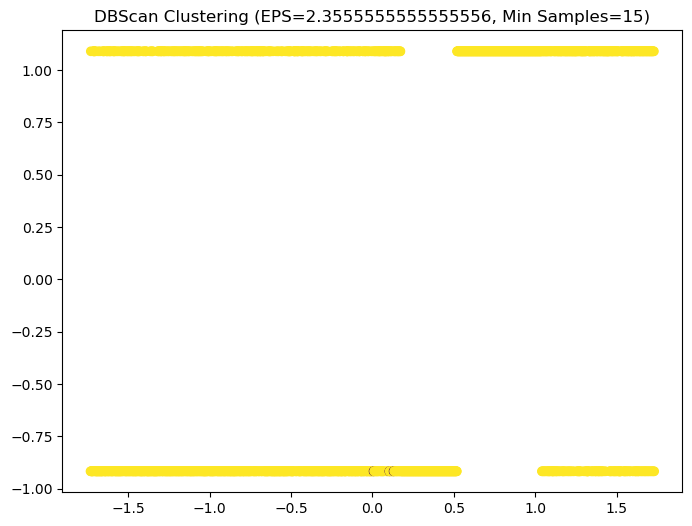

EPS: 2.3555555555555556, Min Samples: 15, Silhouette Score: 0.3152141323662188


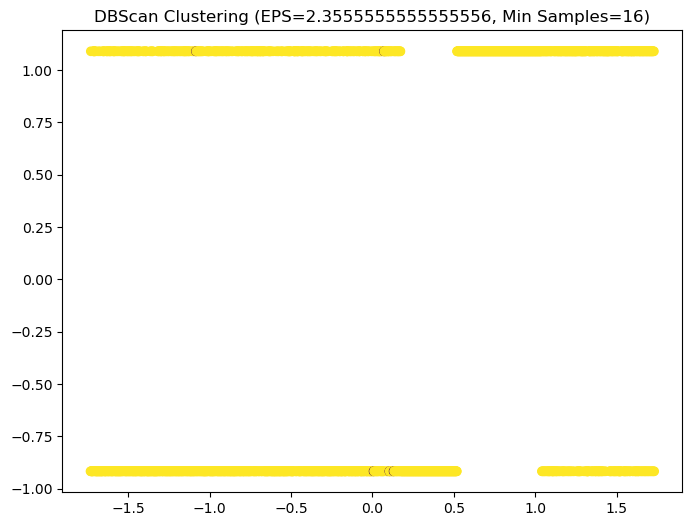

EPS: 2.3555555555555556, Min Samples: 16, Silhouette Score: 0.3646139340695077


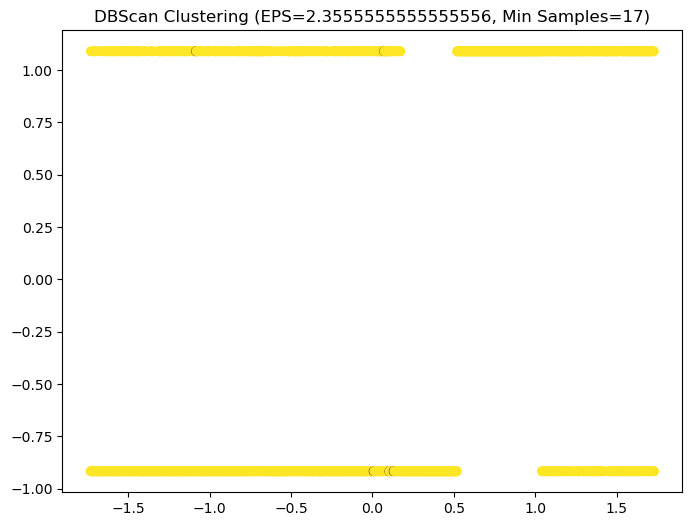

EPS: 2.3555555555555556, Min Samples: 17, Silhouette Score: 0.3646139340695077


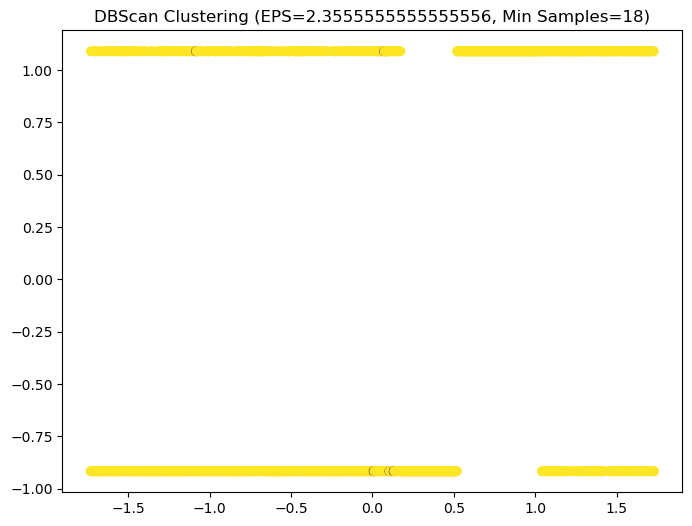

EPS: 2.3555555555555556, Min Samples: 18, Silhouette Score: 0.3646139340695077


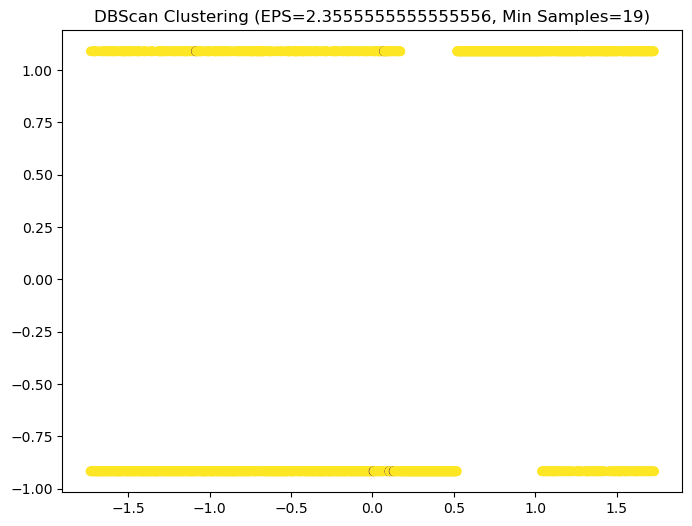

EPS: 2.3555555555555556, Min Samples: 19, Silhouette Score: 0.3646139340695077


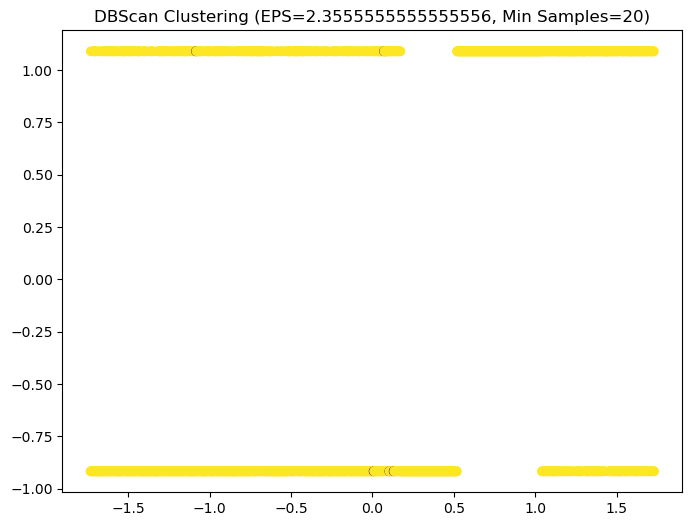

EPS: 2.3555555555555556, Min Samples: 20, Silhouette Score: 0.3646139340695077


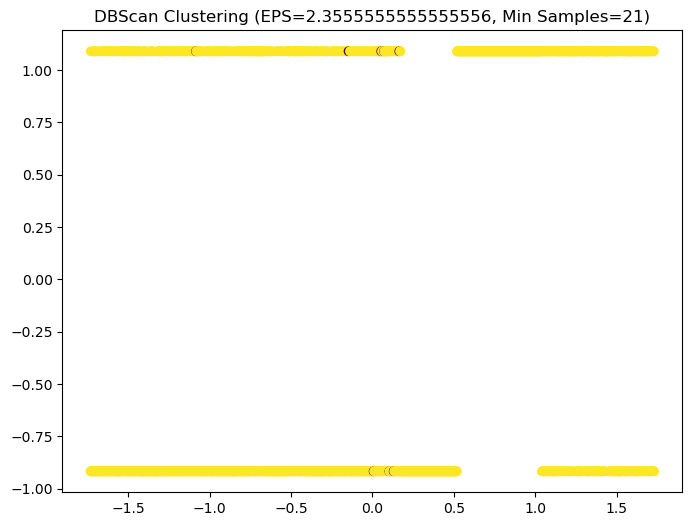

EPS: 2.3555555555555556, Min Samples: 21, Silhouette Score: 0.3373476848490946


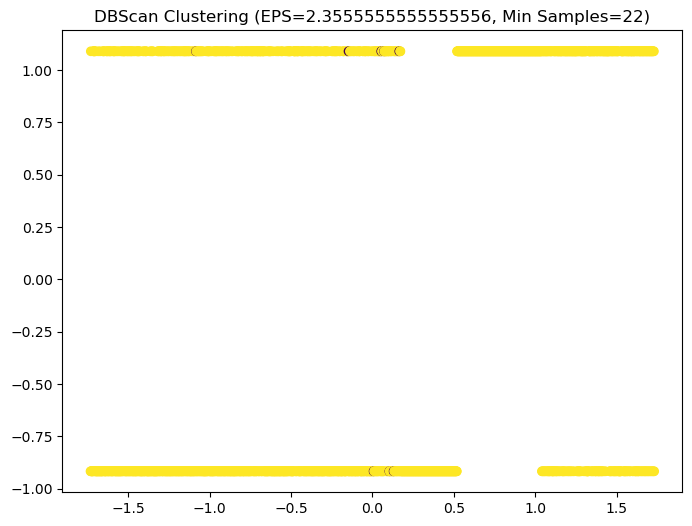

EPS: 2.3555555555555556, Min Samples: 22, Silhouette Score: 0.3373476848490946


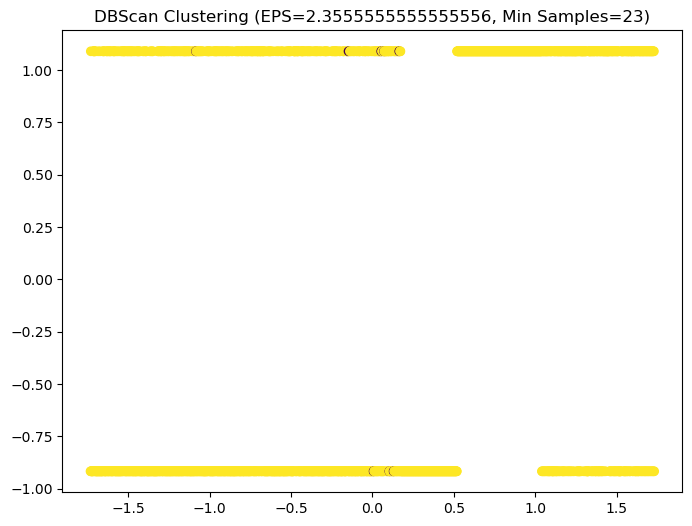

EPS: 2.3555555555555556, Min Samples: 23, Silhouette Score: 0.3373476848490946


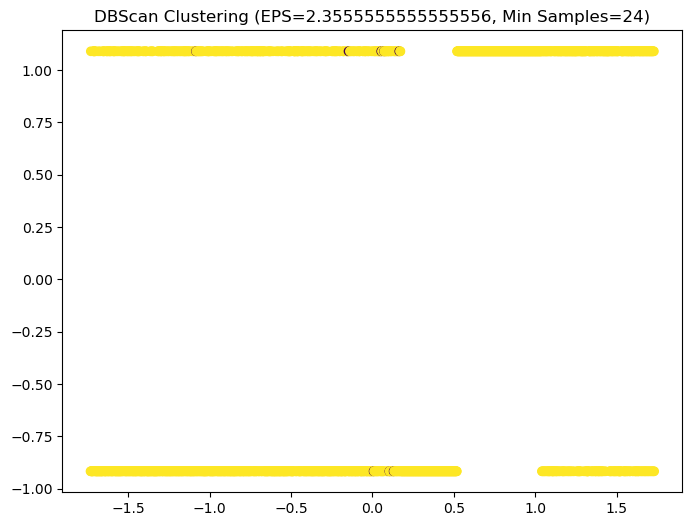

EPS: 2.3555555555555556, Min Samples: 24, Silhouette Score: 0.3373476848490946


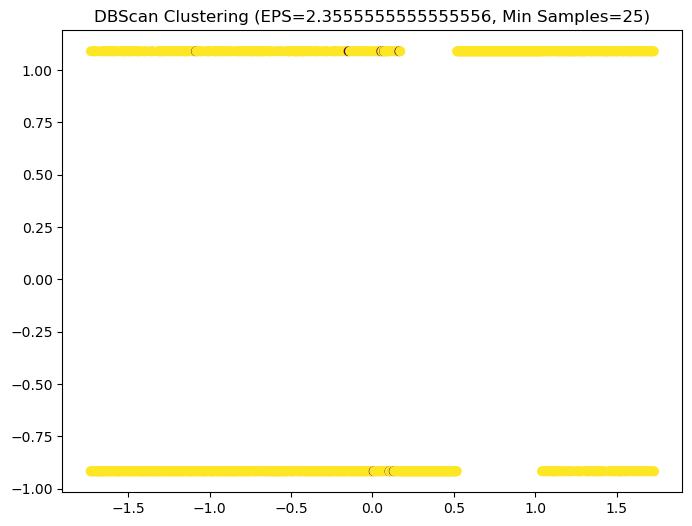

EPS: 2.3555555555555556, Min Samples: 25, Silhouette Score: 0.3373476848490946
Best parameters: EPS=2.3555555555555556, Min Samples=16, Silhouette Score=0.3646139340695077
Best Parameters: {'eps': 2.3555555555555556, 'min_samples': 16}
Best Silhouette Score: 0.3646139340695077


In [99]:
def perform_dbscan_clustering(data, eps_values, min_samples_values):
    best_silhouette_score = -1
    best_params = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            
            # Check if there are at least two unique labels
            unique_labels = np.unique(labels)
            if len(unique_labels) < 2:
                continue
            
            silhouette_score_value = silhouette_score(data, labels)

            # Visualize resulting clusters
            plt.figure(figsize=(8, 6))
            plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
            plt.title(f'DBScan Clustering (EPS={eps}, Min Samples={min_samples})')
            plt.show()

            print(f"EPS: {eps}, Min Samples: {min_samples}, Silhouette Score: {silhouette_score_value}")

            # Store best silhouette score and parameters
            if silhouette_score_value > best_silhouette_score:
                best_silhouette_score = silhouette_score_value
                best_params = {'eps': eps, 'min_samples': min_samples}

    print(f'Best parameters: EPS={best_params["eps"]}, Min Samples={best_params["min_samples"]}, Silhouette Score={best_silhouette_score}')
    return best_params, best_silhouette_score

# Define EPS and Min Samples values to try
eps_values = np.linspace(0.1, 3, 10)
min_samples_values = range(5, 26)

# Perform DBScan clustering
best_params, best_silhouette_score = perform_dbscan_clustering(X_scaled, eps_values, min_samples_values)

print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_silhouette_score)


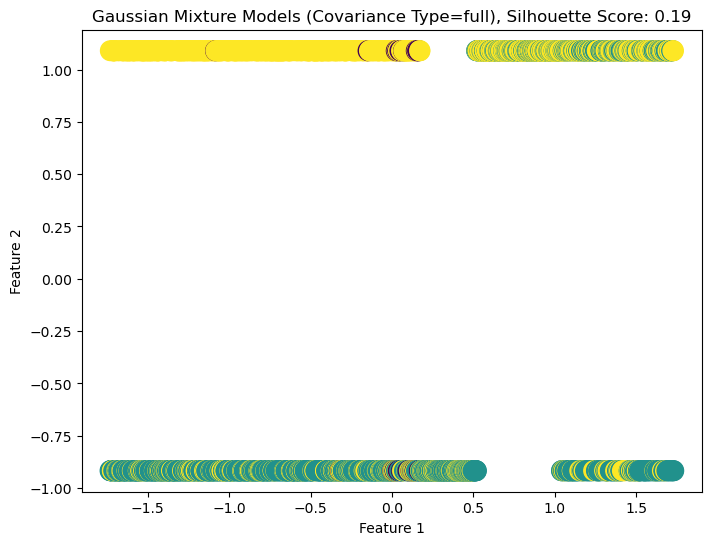

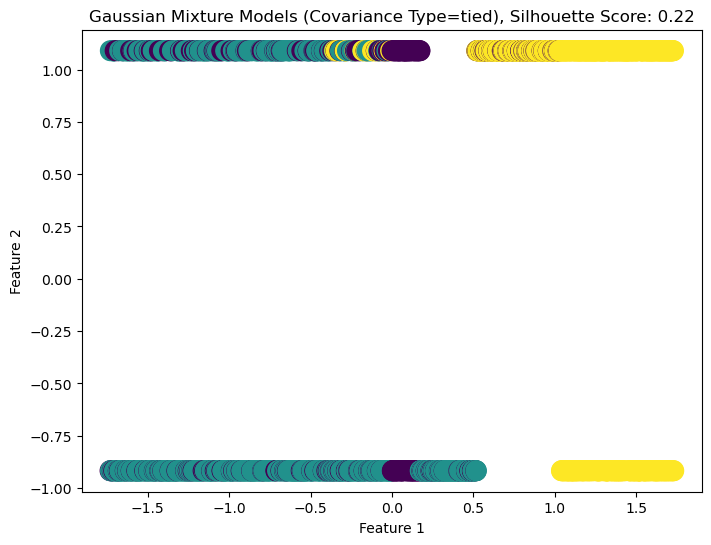

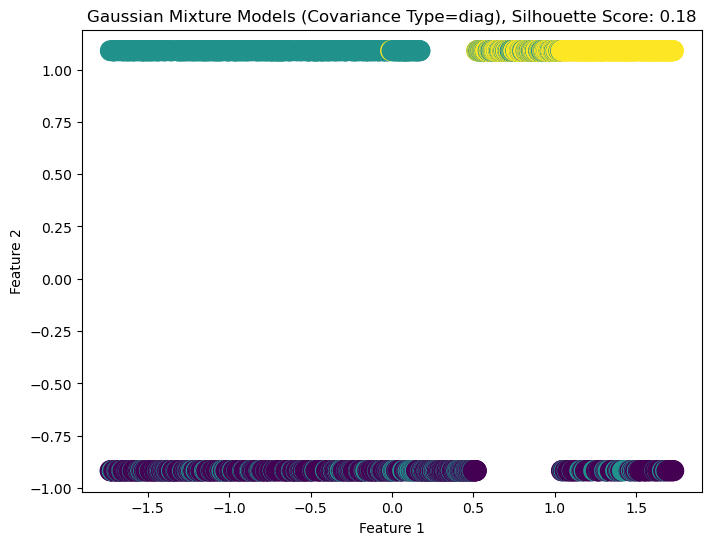

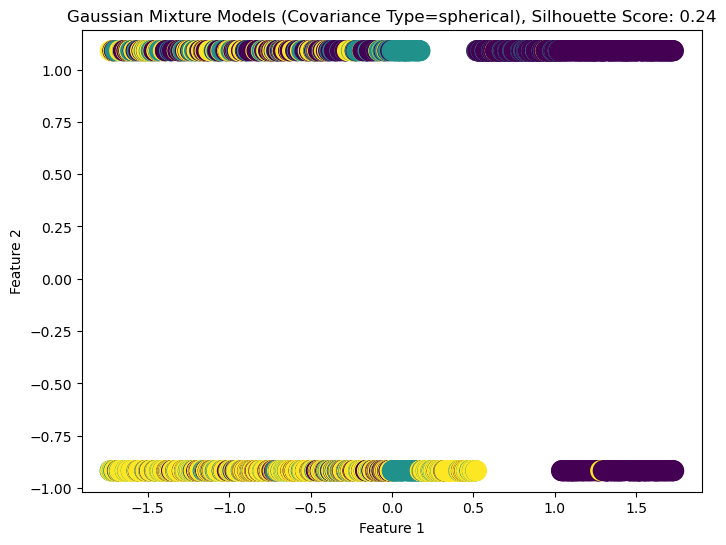

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [53]:
# Initialize lists to store silhouette scores
silhouette_scores_gmm = []

# Covariance types to try
covariance_types = ['full', 'tied', 'diag', 'spherical']

# Iterate over each covariance type
for covariance_type in covariance_types:
    # Fit GMM model
    gmm = GaussianMixture(n_components=3, covariance_type=covariance_type)
    gmm.fit(X_scaled)
    labels_gmm = gmm.predict(X_scaled)
    
    # Calculate silhouette score
    silhouette_avg_gmm = silhouette_score(X_scaled, labels_gmm)
    silhouette_scores_gmm.append((silhouette_avg_gmm, covariance_type))
    
    # Plot 2D contour plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_gmm, cmap='viridis', s=200, alpha=1.0)
    plt.title(f'Gaussian Mixture Models (Covariance Type={covariance_type}), Silhouette Score: {silhouette_avg_gmm:.2f}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Find the best silhouette score and corresponding covariance type
best_score_gmm, best_covariance_type = max(silhouette_scores_gmm)
print
